In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import math
from xgcm import Grid
import xmitgcm
from xmitgcm import open_mdsdataset
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import warnings 
warnings.filterwarnings('ignore')
#import ffmpeg
import matplotlib.gridspec as gridspec
#import metpy.calc as mpcalc
import matplotlib.patches as mpatches
import matplotlib.path as mpath
from matplotlib import cm
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt, animation
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import HTML, display
ffmpeg_path = '/gpfs/software/ada/ffmpeg/4.2.3/bin/ffmpeg'
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path
matplotlib.rcParams['animation.embed_limit'] = 2**128
import nmmn.plots
parula=nmmn.plots.parulacmap()
import matplotlib.ticker as ticker
import nmmn.plots
parula=nmmn.plots.parulacmap()
import matplotlib.patches as patches
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter1d
def convert_coords_to_float32(dataset):
    for coord in dataset.coords:
        if dataset[coord].dtype == '>f4':
            dataset[coord] = dataset[coord].astype('float32')
# Shared font size settings
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 18
title_fontsize = 18



In [2]:
dir="/gpfs/home/bve23zsu/nordic/nordic2.out"  # 5054400 np.arange(5059200, 5400000, 4800).tolist()  #np.arange(5059200, 5400000, 4800).tolist()
#grid_dir='/gpfs/home/bve23zsu/PhDing/MITgcm/verification/glorys_nordic_cos/grid'
#netcdf_grid=xr.open_dataset('/gpfs/home/bve23zsu/PhDing/MITgcm/verification/glorys_nordic_cos/grid.netcdf/MNC_Output_Glued/grid.nc',)#
snap_iters=np.arange(849600, 8208000+1, 4800).tolist() #849600  - 6456000
avg_iters=np.arange(849600, 8208000+1, 4800).tolist()  #849600 - 7156800   #820800
#selected_iters='all'
ds=open_mdsdataset(dir, prefix= ['T','Eta','U','V','S','PH'], iters=snap_iters,delta_t=90, ref_date="1993-08-01T00",default_dtype='float32',ignore_unknown_vars=True,)#

snapshots2D=open_mdsdataset(dir,prefix= ['snapshots2D'],iters=snap_iters, delta_t=90, ref_date="1993-08-01T00",default_dtype='float32',ignore_unknown_vars=True,)
averages2D=open_mdsdataset(dir, prefix= ['averages2D'], iters=avg_iters, delta_t=90, ref_date="1993-08-01T00",default_dtype='float32',ignore_unknown_vars=True,)
averages3D=open_mdsdataset(dir,prefix= ['averages3D'],iters=avg_iters, delta_t=90, ref_date="1993-08-01T00",default_dtype='float32',ignore_unknown_vars=True,)
convert_coords_to_float32(ds)
convert_coords_to_float32(snapshots2D)
convert_coords_to_float32(averages3D)
convert_coords_to_float32(averages2D)

ds['UVELMASS']=averages3D['UVELMASS']
ds['VVELMASS']=averages3D['VVELMASS']
ds['WVELMASS']=averages3D['WVELMASS']

ds['ADVx_TH']=averages3D['ADVx_TH']
ds['ADVy_TH']=averages3D['ADVy_TH']
ds['THETA']=averages3D['THETA']
ds['ETAN']=averages2D['ETAN']

ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point

metrics = {
    ('X'): ['dxC', 'dxG', 'dxF', 'dxV'], # X distances
    ('Y'): ['dyC', 'dyG', 'dyF', 'dyU'], # Y distances
    ('Z'): ['drF', 'drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rAw', 'rAs', 'rA', 'rAz'] # Areas in x-y plane
}

grid = Grid(ds, metrics=metrics,periodic=('X', 'Y'))
Eta_noice=((snapshots2D['sIceLoad'].where(ds.maskInC)/1027)+ds['Eta'])
ds['Eta_noice'] =Eta_noice

from fastjmd95 import rho as densjmd95
grav = 9.81
rhoConst=1027

# theta = ds.T.where(ds.maskC)
# salt = ds.S.where(ds.maskC)
# pres = ds.PH.where(ds.maskC)      #grav*np.abs(-ds.Z)
# rho = xr.apply_ufunc(densjmd95, salt, theta, pres, 
#                      dask='parallelized', output_dtypes=[float,])
# ds['rho'] = rho

ds["YU"], ds["XU"] = xr.broadcast(ds["YC"], ds["XG"])
ds["YV"], ds["XV"] = xr.broadcast(ds["YG"], ds["XC"])


NsASC_index = np.load('NsASC_index.npz')
west_index_x=NsASC_index['west_index_x']
west_index_y=NsASC_index['west_index_y']
east_index_x=NsASC_index['east_index_x']
east_index_y=NsASC_index['east_index_y']
north_index_x=NsASC_index['north_index_x']
north_index_y=NsASC_index['north_index_y']
south_index_x=NsASC_index['south_index_x']
south_index_y=NsASC_index['south_index_y']




# FIG 1

### to manually add AW schematics and key bathymetery features in slides

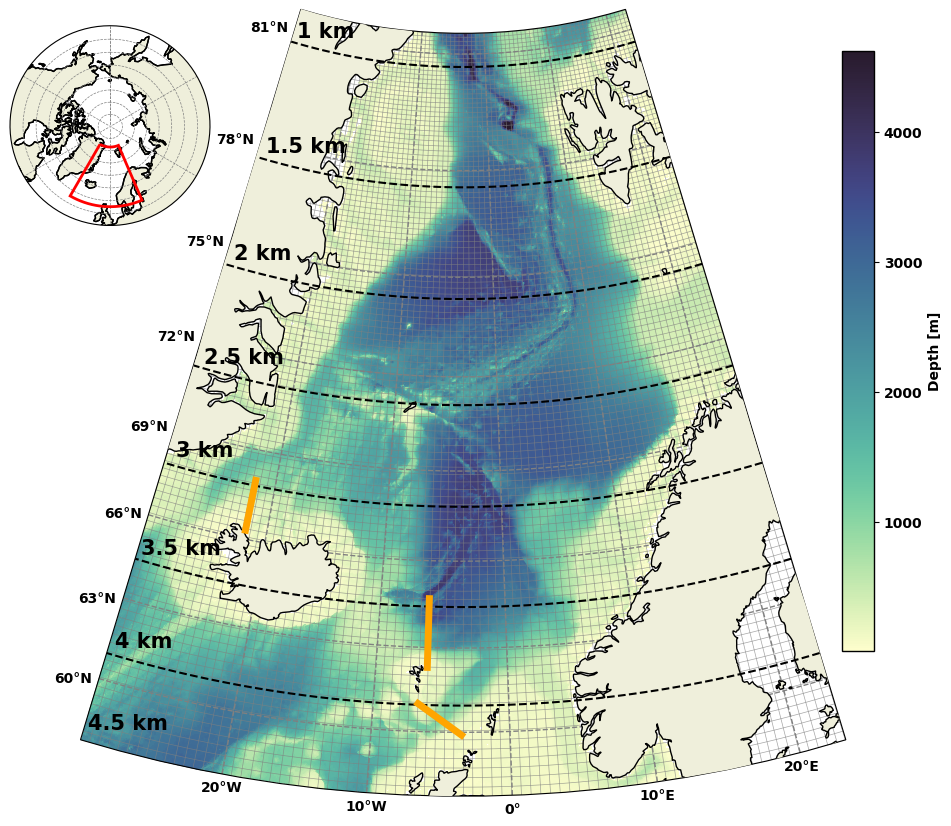

In [3]:
# Define map boundaries and projection
n, lon1, lon2, lat1, lat2 = 20, -30, 23.25, 57.67, 81.5
proj = ccrs.LambertConformal(central_longitude=(lon2 + lon1) / 2,
                             central_latitude=(lat2 + lat1) / 2)

# Create main plot
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': proj}, layout='constrained')
ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())

# Define AOI boundary
aoi = mpath.Path(np.vstack([
    np.column_stack([np.linspace(lon1, lon2, n), np.full(n, lat2)]),  # Top
    np.column_stack([np.full(n, lon2), np.linspace(lat2, lat1, n)]),  # Right
    np.column_stack([np.linspace(lon2, lon1, n), np.full(n, lat1)]),  # Bottom
    np.column_stack([np.full(n, lon1), np.linspace(lat1, lat2, n)])   # Left
]))
ax.set_boundary(aoi, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=3)

# Add gridlines
gl = ax.gridlines(draw_labels=True, rotate_labels=False,
                  x_inline=False, y_inline=False,
                  color='gray', linewidth=1, alpha=1, linestyle="--")
plt.draw()
for ea in gl.ylabel_artists + gl.xlabel_artists:
    pos = ea.get_position()
    if (ea in gl.ylabel_artists and pos[0] > 0) or (ea in gl.xlabel_artists and pos[1] > 0):
        ea.set_visible(False)

# Plot depth
cax = ds.Depth.where(ds.Depth > 0).plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap=cmocean.cm.deep
)

# Colorbar
cbar_ax2 = fig.add_axes([0.99, 0.25, 0.04, 0.6])
cbar = fig.colorbar(cax, cax=cbar_ax2, orientation='vertical', extend='neither', label="Depth [m]")
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('k')
    spine.set_linewidth(1)

# Subsample model grid lines
subsample = 8
xg = ds.XG.values
yg = ds.YG.values
x_subsampled = np.unique(np.concatenate([xg[::subsample], [xg[-1]]]))
y_subsampled = np.unique(np.concatenate([yg[::subsample], [yg[-1]]]))
for x in x_subsampled:
    ax.plot([x, x], [yg.min(), yg.max()], color='gray', linewidth=0.5,
            transform=ccrs.PlateCarree(), alpha=0.7)
for y in y_subsampled:
    ax.plot(x_subsampled, np.repeat(y, len(x_subsampled)), color='gray',
            linewidth=0.5, transform=ccrs.PlateCarree(), alpha=0.7)

# Inset map
inset_ax = fig.add_axes([-0.05, 0.65, 0.25, 0.25], projection=ccrs.NorthPolarStereo())
inset_ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
theta = np.linspace(0, 2 * np.pi, 100)
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * 0.5 + 0.5)
inset_ax.set_boundary(circle, transform=inset_ax.transAxes)
inset_ax.add_feature(cfeature.LAND, edgecolor='black')
inset_ax.coastlines()
inset_ax.gridlines(color='gray', linestyle='--', linewidth=0.5)

# Add AOI to inset
from matplotlib.patches import PathPatch
aoi_patch = PathPatch(aoi, transform=ccrs.PlateCarree(), edgecolor='red',
                      facecolor='none', linewidth=2, linestyle='-', zorder=3)
inset_ax.add_patch(aoi_patch)

# Area contours (km^2 → m^2 → km)
area = ds.rA * 1e-6
cs = np.sqrt(area).plot.contour(
    ax=ax, transform=ccrs.PlateCarree(), colors="k",
    levels=np.arange(1, 5, 0.5), zorder=4, linestyles='--'
)

# Labels for grid cell sizes
# Manually specify locations for labels (adjust based on your data)
label_positions = [(-27, 58.5), (-27.5, 61.5), (-26.5, 65), (-26.7, 68.4), (-25.3, 71.6), (-26, 74.8), (-24, 78), (-25, 81)]
labels = ["4.5 km", "4 km", "3.5 km", "3 km", "2.5 km", "2 km", "1.5 km", "1 km"]
for position, label in zip(label_positions, labels):  # Corrected loop syntax
    ax.text(position[0], position[1], label, fontsize=15, ha='center', transform=ccrs.PlateCarree())

# # Section lines
# linewidth = 3
# color = 'k'
# # Kogur section
# ax.plot([-27.5, -23.77, -22.5], [68.8, 67.52, 66.3], transform=ccrs.PlateCarree(),
#         color=color, linestyle='-', linewidth=linewidth)
# # Iceland-Faroe
# ax.plot([-14., -7], [65.3, 62.3], transform=ccrs.PlateCarree(),
#         color=color, linestyle='-', linewidth=linewidth)
# # Faroe-Shetland
# ax.plot([-6.8, -1.3], [62, 60.58], transform=ccrs.PlateCarree(),
#         color=color, linestyle='-', linewidth=linewidth)

lons_GSR1, lats_GSR1 = [-21.8, -21.8],[66.3,68]
lons_GSR2, lats_GSR2 = [-6.1,-6.1],[62.3,64.7]
lons_GSR3, lats_GSR3 = [-6.7, -3.5],[61,59.9]
color='orange'
linewidth=5
ax.plot(lons_GSR1, lats_GSR1,transform=ccrs.PlateCarree(),color=color, linestyle='-',  linewidth=linewidth,zorder=5) 
ax.plot(lons_GSR2, lats_GSR2,transform=ccrs.PlateCarree(),color=color, linestyle='-',  linewidth=linewidth,zorder=5) 
ax.plot(lons_GSR3, lats_GSR3,transform=ccrs.PlateCarree(),color=color, linestyle='-',  linewidth=linewidth,zorder=5) 

# Show plot
plt.show()
fig.savefig('../Manuscript/FIGs/FIG1.png', bbox_inches='tight', transparent=True,dpi=500)



# FIG2

In [4]:
# Obsevration
Satellite=xr.open_mfdataset(os.path.join('/gpfs/home/bve23zsu/nordic/OBSERVATION/copernicus-data/Altimeter/', 
    "cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_ugos-vgos-sla_30.88W-23.88E_57.12N-81.88N*"),chunks={"time": 1},combine="by_coords",
)
OSTIA=xr.open_mfdataset(os.path.join('/gpfs/home/bve23zsu/nordic/datainput/sst', 
    "METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2*"),chunks={"time": 1},combine="by_coords",
)
# choose 2008-2013 data
Satellite_2008_2013 = Satellite.sel(time=slice('2008-01-01','2013-12-31')).sel(longitude=slice(-30.5,23.5), latitude=slice(57.12,81.88))
OSTIA_sst=OSTIA.analysed_sst.sel(time=slice('2008-01-01','2013-12-31')).sel(longitude=slice(-30.5,23.5), latitude=slice(57.12,81.88))-273.15
OSTIA_ice=OSTIA.sea_ice_fraction.sel(time=slice('2008-01-01','2013-12-31')).sel(longitude=slice(-30.5,23.5), latitude=slice(57.12,81.88))


In [5]:
%%time
ugos = Satellite_2008_2013['ugos'].compute() #.mean('time')
vgos = Satellite_2008_2013['vgos'].compute()#.mean('time')
## interpolate to model grid

ds_out = xr.Dataset(coords={"lon": ds["XC"], "lat": ds["YC"]})
import xesmf as xe

regridder = xe.Regridder(OSTIA_sst, ds_out, "patch",)                      
regridder._grid_in = None
regridder._grid_out = None
sst_interp = regridder(OSTIA_sst)

OSTIA_seaice = OSTIA_ice
regridder = xe.Regridder(OSTIA_seaice, ds_out, "patch",)                      
regridder._grid_in = None
regridder._grid_out = None
OSTIA_seaice_interp = regridder(OSTIA_seaice)


regridder = xe.Regridder(ugos, ds_out, "patch",)                      
regridder._grid_in = None
regridder._grid_out = None
ugos_interp = regridder(ugos)
vgos_interp = regridder(vgos)

spd_geo= (ugos_interp**2 + vgos_interp**2)**(1/2)



CPU times: user 6min 18s, sys: 16.7 s, total: 6min 34s
Wall time: 6min 33s


In [6]:
### plot 1
lon_min, lon_max = 15.0, 23.25
lat_min, lat_max = 57.67, 68.0
# Create a mask: True for values inside the region to mask
baltic_mask = ((sst_interp.lon >= lon_min) & (sst_interp.lon <= lon_max) & (sst_interp.lat >= lat_min) & (sst_interp.lat <= lat_max))


In [7]:


NsASC_index = np.load('../Paper1_AW_heat_transport/NsASC_index.npz')
west_index_x=NsASC_index['west_index_x']
west_index_y=NsASC_index['west_index_y']
east_index_x=NsASC_index['east_index_x']
east_index_y=NsASC_index['east_index_y']
north_index_x=NsASC_index['north_index_x']
north_index_y=NsASC_index['north_index_y']
south_index_x=NsASC_index['south_index_x']
south_index_y=NsASC_index['south_index_y']

def extract_western_mooring():
    mooring_1 = ds.isel(XC=xr.DataArray(west_index_x[:328], dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(west_index_y[:328], dims='mooring'),
                      YG=xr.DataArray(west_index_y[:328]+1, dims='mooring'),
                        XG=xr.DataArray(west_index_x[:328], dims='mooring'),) 
    
    mooring_2 = ds.isel(XC=xr.DataArray(west_index_x[328:465], dims='mooring'),
                    YC=xr.DataArray(west_index_y[328:465], dims='mooring'),
                      YG=xr.DataArray(west_index_y[328:465], dims='mooring'),
                        XG=xr.DataArray(west_index_x[328:465], dims='mooring'),)
    
    mooring_3 = ds.isel(XC=xr.DataArray(west_index_x[465:528], dims='mooring'),
                    YC=xr.DataArray(west_index_y[465:528], dims='mooring'),
                      YG=xr.DataArray(west_index_y[465:528]+1, dims='mooring'),
                        XG=xr.DataArray(west_index_x[465:528], dims='mooring'),)
    
    mooring_4 = ds.isel(XC=xr.DataArray(west_index_x[528:627], dims='mooring'),
                    YC=xr.DataArray(west_index_y[528:627], dims='mooring'),
                      YG=xr.DataArray(west_index_y[528:627], dims='mooring'),
                        XG=xr.DataArray(west_index_x[528:627], dims='mooring'),)
    
    mooring_5 = ds.isel(XC=xr.DataArray(west_index_x[627:648], dims='mooring'),
                    YC=xr.DataArray(west_index_y[627:648], dims='mooring'),
                      YG=xr.DataArray(west_index_y[627:648]+1, dims='mooring'),
                        XG=xr.DataArray(west_index_x[627:648], dims='mooring'),)
    
    mooring_6 = ds.isel(XC=xr.DataArray(west_index_x[648:], dims='mooring'),
                    YC=xr.DataArray(west_index_y[648:], dims='mooring'),
                      YG=xr.DataArray(west_index_y[648:], dims='mooring'),
                        XG=xr.DataArray(west_index_x[648:], dims='mooring'),)
    
    west_mooring_way2 = xr.concat([mooring_1, mooring_2,mooring_3, mooring_4,mooring_5, mooring_6],dim='mooring')

    U_dir = np.zeros(len(west_mooring_way2.XC))
    V_dir = np.zeros(len(west_mooring_way2.YC))
    diffX = np.diff(west_mooring_way2.XC) 
    diffY = np.diff(west_mooring_way2.YC) 
    
    # the frist and last mooring is not calculated
    for i in range(len(diffX)-1):
        if diffX[i] > 0 :  # zonal mooring,  calculate  V flux, out is neg
            V_dir[i ] = -1
        elif diffX[i] < 0 :  # zonal mooring,  calculate  V flux, in is pos
            V_dir[i+1 ] = 1
        elif diffX[i] == 0 and diffX[i+1] == 0: #merional calculate U, 
            U_dir[i+1 ] = 1   
        elif diffY[i] > 0 and diffX[i + 1] > 0:  # |‾
            U_dir[i+1 ] = 1
        if diffX[i] < 0 and diffY[i + 1] > 0: #|_
            U_dir[i+1] = 1
    return west_mooring_way2, U_dir, V_dir
            
def extract_eastern_mooring():
    mooring_1 = ds.isel(XC=xr.DataArray(east_index_x[:339], dims='mooring'),
                    YC=xr.DataArray(east_index_y[:339], dims='mooring'),
                      YG=xr.DataArray(east_index_y[:339], dims='mooring'),
                        XG=xr.DataArray(east_index_x[:339]+1, dims='mooring'),) 
    
    mooring_2 = ds.isel(XC=xr.DataArray(east_index_x[339:463], dims='mooring'),
                    YC=xr.DataArray(east_index_y[339:463], dims='mooring'),
                      YG=xr.DataArray(east_index_y[339:463]+1, dims='mooring'),
                        XG=xr.DataArray(east_index_x[339:463]+1, dims='mooring'),) 
    
    mooring_3 = ds.isel(XC=xr.DataArray(east_index_x[463:524], dims='mooring'),
                    YC=xr.DataArray(east_index_y[463:524], dims='mooring'),
                      YG=xr.DataArray(east_index_y[463:524], dims='mooring'),
                        XG=xr.DataArray(east_index_x[463:524]+1, dims='mooring'),) 
    
    mooring_4 = ds.isel(XC=xr.DataArray(east_index_x[524:852], dims='mooring'),
                    YC=xr.DataArray(east_index_y[524:852], dims='mooring'),
                      YG=xr.DataArray(east_index_y[524:852]+1, dims='mooring'),
                        XG=xr.DataArray(east_index_x[524:852]+1, dims='mooring'),) 
    east_mooring_way2 = xr.concat([mooring_1, mooring_2,mooring_3, mooring_4,],dim='mooring')
    
    
    U_dir = np.zeros(len(east_mooring_way2.XC))
    V_dir = np.zeros(len(east_mooring_way2.YC))
    diffX = np.diff(east_mooring_way2.XC) 
    diffY = np.diff(east_mooring_way2.YC) 
    
    # the frist and last mooring is not calculated
    for i in range(len(diffX)-1):
        if diffX[i] > 0 :  # zonal mooring,  calculate  V flux, out is neg
            V_dir[i+1 ] = 1
        elif diffX[i] < 0 :  # zonal mooring,  calculate  V flux, in is pos
            V_dir[i] = -1
        elif diffX[i] == 0 and diffX[i+1] == 0: #merional calculate U, 
            U_dir[i+1] = 1   
        # elif diffY[i] > 0 and diffX[i + 1] > 0:  # |‾
        #     U_dir[i+1 ] = 1
        if diffX[i] == 0 and diffX[i + 1] < 0: #‾|
            U_dir[i+1] = 1
        if diffX[i] > 0 and diffX[i + 1]== 0: #|‾
            U_dir[i+1] = 1    
    return east_mooring_way2, U_dir, V_dir
    
# np.where(np.diff(east_index_x)==-1)
# np.where(np.diff(east_index_x)==1)
west_mooring_way2, west_mooring_U_dir, west_mooring_V_dir = extract_western_mooring()
west_mooring_U_dir[[0,-1]] = 1

east_mooring_way2, east_mooring_U_dir, east_mooring_V_dir = extract_eastern_mooring()
east_mooring_U_dir[[0,-1]] = 1

mooring_north = ds.isel(XC=xr.DataArray(np.arange(433,473+1), dims='mooring'), ##remove 1 corner to facilitate calculation
                YC=xr.DataArray(np.full(41, 758), dims='mooring'),
                  YG=xr.DataArray(np.full(41, 758)+1, dims='mooring'),
                XG=xr.DataArray(np.arange(433,473+1), dims='mooring'),)

mooring_south = ds.isel(XC=xr.DataArray(np.arange(413, 434+1), dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(np.full(22, 168), dims='mooring'),
                      YG=xr.DataArray(np.full(22, 168), dims='mooring'),
                        XG=xr.DataArray(np.arange(413, 434+1), dims='mooring'),)

south_face = np.column_stack((mooring_south.XC.values, mooring_south.YC.values -0.036026 ))
north_face = np.column_stack((mooring_north.XC.values, mooring_north.YC.values))
west_face = np.column_stack((west_mooring_way2.XC.values, west_mooring_way2.YC.values))
east_face = np.column_stack((east_mooring_way2.XC.values, east_mooring_way2.YC.values))



In [8]:
sel_time=slice('2011-01-01','2011-12-31')
satellite_sst = sst_interp.sel(time=sel_time).mean('time').compute()
model_sst =ds.T.isel(Z=0).sel(time=sel_time).mean('time').where(ds.maskC[0]).compute()


In [9]:
satellite_u = ugos_interp.sel(time=sel_time).mean('time').compute()
satellite_v = vgos_interp.sel(time=sel_time).mean('time').compute()

In [10]:
def geostrophic_velocity_avg():
    lon,lat=np.meshgrid(ds.XC,ds.YC)
    omega = 7.2921e-5
    f = 2 * omega * np.sin(np.deg2rad(lat))
    rhoConst = 1027
    g=9.8156
    
    ETAN_noice=((averages2D['sIceLoad'].where(ds.maskInC)/1027)+averages2D['ETAN'])
    
    dedy=grid.derivative(ETAN_noice.where(ds.maskInC), 'Y', boundary='fill',fill_value=np.nan) 
    dedx= grid.derivative(ETAN_noice.where(ds.maskInC), 'X', boundary='fill',fill_value=np.nan)

    ug=-g/f * dedy
    vg=g/f* dedx
    
    ug_avg=grid.interp((ug*ds.maskInS), 'Y',boundary='fill',fill_value=np.nan)
    vg_avg=grid.interp((vg*ds.maskInW), 'X',boundary='fill',fill_value=np.nan)
    geo_avg=(ug_avg**2 + vg_avg**2)**(1/2)
    geo_avg.attrs["long_name"] = "Geostrophic speed"
    return ug_avg,vg_avg,geo_avg
ug_avg,vg_avg,geo_avg = geostrophic_velocity_avg()



In [11]:
# def geostrophic_velocity_snap():
#     lon,lat=np.meshgrid(ds.XC,ds.YC)
#     omega = 7.2921e-5
#     f = 2 * omega * np.sin(np.deg2rad(lat))
#     rhoConst = 1027
#     g=9.8156
    
#     ETAN_noice=((snapshots2D['sIceLoad'].where(ds.maskInC)/1027)+ds['Eta'])
    
#     dedy=grid.derivative(ETAN_noice.where(ds.maskInC), 'Y', boundary='fill',fill_value=np.nan) 
#     dedx= grid.derivative(ETAN_noice.where(ds.maskInC), 'X', boundary='fill',fill_value=np.nan)

#     ug=-g/f * dedy
#     vg=g/f* dedx
    
#     ug_avg=grid.interp((ug*ds.maskInS), 'Y',boundary='fill',fill_value=np.nan)
#     vg_avg=grid.interp((vg*ds.maskInW), 'X',boundary='fill',fill_value=np.nan)
#     geo_avg=(ug_avg**2 + vg_avg**2)**(1/2)
#     geo_avg.attrs["long_name"] = "Geostrophic speed"
#     return ug_avg,vg_avg,geo_avg
# ug_snap,vg_snap,geo_snap = geostrophic_velocity_snap()


In [12]:
# mask out baltic sea
lon_min, lon_max = 15.0, 23.25
lat_min, lat_max = 57.67, 68.0
# Create a mask: True for values inside the region to mask
sel_time=slice('2011-01-01','2011-12-31')

baltic_mask = ((sst_interp.lon >= lon_min) & (sst_interp.lon <= lon_max) & (sst_interp.lat >= lat_min) & (sst_interp.lat <= lat_max))
satellite_seaice = OSTIA_seaice_interp.where(~baltic_mask).sel(time=sel_time).groupby('time.month').mean('time').compute()
model_seaice=snapshots2D['SIarea'].where(ds.maskC[0]).sel(time=sel_time).where(~baltic_mask).groupby('time.month').mean('time').compute()


# Svinoy T and V

In [13]:
### Svinoy
import pandas as pd
# Read CSV file
svinoy_t_3m = pd.read_csv("../Chapter2-Validation/svinoy_t_3m.csv", header=None) #299
svinoy_t_1y = pd.read_csv("../Chapter2-Validation/svinoy_t_1y.csv", header=None)  #289
svinoy_v_3m = pd.read_csv("../Chapter2-Validation/svinoy_v_3m.csv", header=None)  #298
svinoy_v_1y = pd.read_csv("../Chapter2-Validation/svinoy_v_1y.csv", header=None) #289

svinoy_t_3m = svinoy_t_3m.iloc[:, 1].to_numpy()
svinoy_t_1y = svinoy_t_1y.iloc[:, 1].to_numpy()
svinoy_v_3m = svinoy_v_3m.iloc[:, 1].to_numpy()
svinoy_v_1y = svinoy_v_1y.iloc[:, 1].to_numpy()


Orvik_monthly_time_axis = pd.date_range(start='1995-06', end='2020-03', freq='MS')+ pd.DateOffset(days=14)
Orvik_yearly_time_axis = pd.date_range(start='1995-11', end='2019-11', freq='MS')+ pd.DateOffset(days=14)


Orvik = xr.Dataset({
    "svinoy_t_3m": ("x_axis_1", svinoy_t_3m[1:]),
    "svinoy_t_1y": ("x_axis_2", svinoy_t_1y),
    
    "svinoy_v_3m": ("x_axis_1", svinoy_v_3m),
    "svinoy_v_1y": ("x_axis_2", svinoy_v_1y),
    
    },
    coords={
        "x_axis_1":Orvik_monthly_time_axis ,
        "x_axis_2":Orvik_yearly_time_axis 
            })

In [14]:
#=====================  model ===============#
# Extract variables
U = ds["U"]
V = ds["V"]
# Interpolate horizontal velocities
U = grid.interp(U, "X", boundary="fill", fill_value=np.nan)
V = grid.interp(V, "Y", boundary="fill", fill_value=np.nan)
# Compute horizontal velocity magnitude
hor_vel = np.sqrt(np.power(U, 2) + np.power(V, 2))
# Create DataArray
hor_vel.attrs["units"] = "m/s"
ds['hor_vel']=hor_vel
svinoy_vel = ds['hor_vel'].sel(Z=-100,XC=4.4, YC=62.8,method='nearest').sel(time=slice('1996-01-01','2016-12-31'))
svinoy_vel_values=svinoy_vel.resample(time='M').mean('time').values
svinoy_vel = xr.DataArray(
    svinoy_vel_values,  # Your NumPy array
    dims=['time'],  # Name of the dimension
    coords={'time': svinoy_vel.resample(time='M').mean('time').time},  # Assign the time axis as a coordinate
    name='svinoy_vel'  # Name of the DataArray
)



In [15]:
#=====================  model ===============#
# Extract variables
U = ds["UVELMASS"]
V = ds["VVELMASS"]
# Interpolate horizontal velocities
U = grid.interp(U, "X", boundary="fill", fill_value=np.nan)
V = grid.interp(V, "Y", boundary="fill", fill_value=np.nan)
# Compute horizontal velocity magnitude
hor_vel = np.sqrt(np.power(U, 2) + np.power(V, 2))
# Create DataArray
hor_vel.attrs["units"] = "m/s"
ds['hor_vel']=hor_vel
svinoy_vel_avg = ds['hor_vel'].sel(Z=-100,XC=4.4, YC=62.8,method='nearest').sel(time=slice('1996-01-01','2016-12-31'))
svinoy_vel_avg_values=svinoy_vel_avg.resample(time='M').mean('time').values
svinoy_vel_avg = xr.DataArray(
    svinoy_vel_avg_values,  # Your NumPy array
    dims=['time'],  # Name of the dimension
    coords={'time': svinoy_vel.resample(time='M').mean('time').time},  # Assign the time axis as a coordinate
    name='svinoy_vel'  # Name of the DataArray
)


In [16]:
# avg_iters_all=np.arange(4800, 8208000+1, 4800).tolist()
# averages3D_copy = open_mdsdataset(dir,prefix= ['averages3D'],iters=avg_iters_all, delta_t=90, ref_date="1993-08-01T00",default_dtype='float32',ignore_unknown_vars=True,)
# convert_coords_to_float32(averages3D_copy)

In [17]:
# convert_coords_to_float32(averages3D_copy)

In [19]:
# load additional 3 months data before 1996-01-01
#THETA_svinoy = averages3D_copy['THETA'].sel(Z=-100,XC=4.1, YC=62.9,method='nearest').sel(time=slice('1995-10-01','2016-12-31'))

In [22]:
svinoy_t = averages3D['THETA'].sel(Z=-100,XC=4.1, YC=62.9,method='nearest').sel(time=slice('1996-01-01','2016-12-31'))
svinoy_t_values=svinoy_t.values
svinoy_t = xr.DataArray(
    svinoy_t_values,  # Your NumPy array
    dims=['time'],  # Name of the dimension
    coords={'time': svinoy_t.time},#pd.date_range(start='1995-04', end='2016-12', freq='MS')+ pd.DateOffset(days=14)}, # Assign the time axis as a coordinate
    name='svinoy_temperature')  # Name of the DataArray)

svinoy_t_3m = (svinoy_t-svinoy_t_values.mean()).rolling(time=18, center=False).mean().sel(time=slice('1996-01-01','2016-12-31'))
#svinoy_t_12m = (svinoy_t-svinoy_t_values.mean()).rolling(time=72, center=False).mean()

In [23]:
# svinoy_t = THETA_svinoy
# svinoy_t_values=svinoy_t.values
# svinoy_t = xr.DataArray(
#     svinoy_t_values,  # Your NumPy array
#     dims=['time'],  # Name of the dimension
#     coords={'time': svinoy_t.time},#pd.date_range(start='1995-04', end='2016-12', freq='MS')+ pd.DateOffset(days=14)}, # Assign the time axis as a coordinate
#     name='svinoy_temperature')  # Name of the DataArray)

# svinoy_t_3m = (svinoy_t-svinoy_t_values.mean()).rolling(time=18, center=False).mean().sel(time=slice('1996-01-01','2016-12-31'))


In [25]:
time_slice=slice('1996-01-01','2016-12-31')
svinoy_t_3m_model=svinoy_t_3m.sel(time=time_slice)
#svinoy_t_1y_model=svinoy_t_12m.sel(time=time_slice)

In [26]:
svinoy_t_3m_obs = Orvik['svinoy_t_3m'].sel(x_axis_1=time_slice)
svinoy_t_1y_obs = Orvik['svinoy_t_1y'].sel(x_axis_2=time_slice)

In [27]:
print("Model Mean =", f"{svinoy_t_values.mean():.1f}","Std =", f"{svinoy_t_values.std():.1f}",
     "Max =", f"{svinoy_t_values.max():.1f}","Min =", f"{svinoy_t_values.min():.1f}")

print("Observed Mean =", f"{svinoy_t_3m_obs.mean():.1f}","Std =", f"{svinoy_t_3m_obs.std():.1f}",
     "Max =", f"{svinoy_t_3m_obs.max():.1f}","Min =", f"{svinoy_t_3m_obs.min():.1f}")

Model Mean = 8.5 Std = 0.7 Max = 10.3 Min = 6.2
Observed Mean = 0.0 Std = 0.5 Max = 1.3 Min = -1.1


In [28]:
svinoy_v_ano = ((svinoy_vel-svinoy_vel.mean())*100)
#svinoy_v_ano_12m = svinoy_v_ano.rolling(time=12, center=True).mean()
svinoy_v_ano_3m = svinoy_v_ano.rolling(time=3, center=True).mean()


svinoy_v_ano_avg = ((svinoy_vel_avg-svinoy_vel_avg.mean())*100)
#svinoy_v_ano_12m = svinoy_v_ano.rolling(time=12, center=True).mean()
svinoy_v_ano_3m_avg = svinoy_v_ano_avg.rolling(time=3, center=True).mean()



In [29]:
print("V Model Mean =", f"{svinoy_vel_values.mean():.3f}","Std =", f"{svinoy_vel_values.std():.3f}",
     "Max =", f"{svinoy_vel_values.max():.3f}","Min =", f"{svinoy_vel_values.min():.3f}")

print("V_avg Model Mean =", f"{svinoy_vel_avg_values.mean():.3f}","Std =", f"{svinoy_vel_avg_values.std():.3f}",
     "Max =", f"{svinoy_vel_avg_values.max():.3f}","Min =", f"{svinoy_vel_avg_values.min():.3f}")



V Model Mean = 0.262 Std = 0.068 Max = 0.449 Min = 0.095
V_avg Model Mean = 0.257 Std = 0.064 Max = 0.459 Min = 0.106


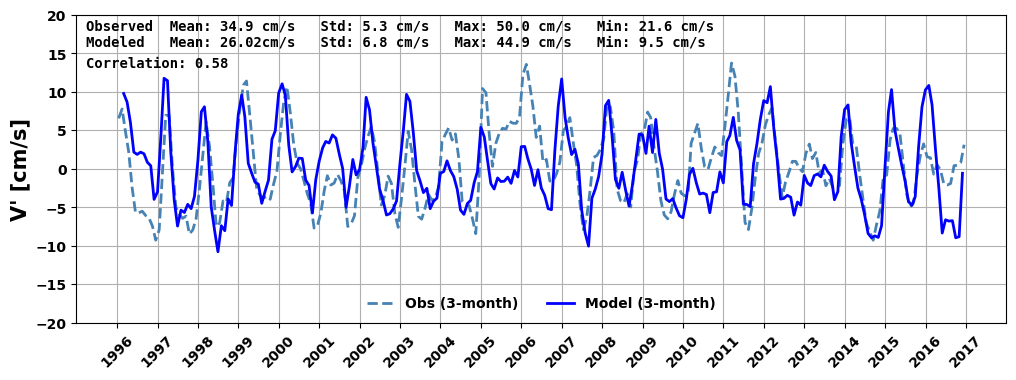

In [30]:
## Fancy, distinct color palette
colors = {
    'obs_12m': 'orange',      # warm orange
    'obs_3m': 'steelblue',       # peach
    'model_3m': 'b',     # teal
    'model_12m': 'r',    # deep blue-green
}
linewidth1 = 2
linewidth3 = 3

fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.set_ylim(-20, 20)

time_slice=slice('1996-01-01','2016-12-31')

Orvik.svinoy_v_3m.sel(x_axis_1=time_slice).plot(ax=axes,label='Obs (3-month)', color=colors['obs_3m'], lw=linewidth1, linestyle='--',)
svinoy_v_ano_3m.sel(time=time_slice).plot(ax=axes, lw=linewidth1, label='Model (3-month)', color=colors['model_3m'], linestyle='-')
#svinoy_v_ano_3m_avg.sel(time=time_slice).plot(ax=axes, lw=linewidth1, label='Model (3-month) avg', color='r', linestyle='-')

# Orvik.svinoy_v_1y.sel(x_axis_2=time_slice).plot(ax=axes,label='Obs (12-month)', color=colors['obs_12m'], lw=3, linestyle='--',)
# svinoy_v_ano_12m.sel(time=time_slice).plot(ax=axes, lw=3, label='Model(12-month)', color=colors['model_12m'],  linestyle='-')

axes.set_xticks(pd.date_range(start="1996-01", end="2017-12", freq='YS'), labels=[str(year) for year in range(1996, 2018)], rotation=45, ha='center')
axes.grid()
axes.set_xlabel('')
axes.legend( ncols=2,loc="lower center",framealpha=0.)  

# axes[0].legend( ncols=2,loc="best")   
# axes[1].legend( ncols=2,loc="best")   
axes.set_ylabel("V' [cm/s]",fontsize=15,)
axes.text(0.01, 0.95, 
    "Observed  Mean: 34.9 cm/s   Std: 5.3 cm/s   Max: 50.0 cm/s   Min: 21.6 cm/s",
    fontsize=10, transform=axes.transAxes, weight="bold", family="monospace")

axes.text(0.01, 0.90, 
    "Modeled   Mean: 26.02cm/s   Std: 6.8 cm/s   Max: 44.9 cm/s   Min: 9.5 cm/s",
    fontsize=10, transform=axes.transAxes, weight="bold", family="monospace")

axes.text(0.01, 0.83, 
    "Correlation: 0.58",
    fontsize=10, transform=axes.transAxes, weight="bold", family="monospace")

plt.show()

fig.savefig('../Manuscript/FIGs/SUP1.png', bbox_inches='tight', transparent=True,dpi=500)


# AW volume transport

In [31]:
# Obs https://www.ocean-ops.org/oceansites/tma/gsr.html
GSR_1 = xr.open_dataset('../Paper1_AW_heat_transport/Obs/OS_2_GSR_1_NIIC_transport_1994_2016_D.nc')
GSR_2 = xr.open_dataset('../Paper1_AW_heat_transport/Obs/OS_2_GSR_2_FC_transport_1995_2017_D.nc')  #  4 ◦ C isotherm
GSR_3 = xr.open_dataset('../Paper1_AW_heat_transport/Obs/OS_2_GSR_3_SBNAC_transport_1993_2017_D.nc')

GSR_NIIC = GSR_1.NIIC_trsp.squeeze().sel(TIME=slice('1996-01-01','2016-07-31')).values
# fill 3 nan in GSR 1
# Step 1: Get indices of non-NaN values
valid_mask = ~np.isnan(GSR_NIIC)
valid_indices = np.where(valid_mask)[0]  # e.g., [0, 1, 3, 5, 6]
valid_values = GSR_NIIC[valid_mask]          # e.g., [1, 2, 4, 6, 7]
# Step 2: Generate indices for all positions (including NaNs)
all_indices = np.arange(len(GSR_NIIC))       # e.g., [0, 1, 2, 3, 4, 5, 6, 7]
# Step 3: Interpolate NaNs using np.interp
interpolated_GSR_NIIC = np.interp(all_indices, valid_indices, valid_values)
GSR_1_3m_running_mean = GSR_1.NIIC_trsp.squeeze().rolling(TIME=3, center=True).mean()
GSR_2_3m_running_mean = GSR_2.FC_mnt_tr.squeeze().rolling(TIME=3, center=True).mean()
GSR_3_3m_running_mean = GSR_3.SB_trsp_altimetry.squeeze().rolling(TIME=3, center=True).mean()

GSR_NIIC  = GSR_1.NIIC_trsp.squeeze()
GSR_IF = GSR_2.FC_mnt_tr.squeeze()
GSR_FS = GSR_3.SB_trsp_altimetry.squeeze()

GSR_all_obs = interpolated_GSR_NIIC +\
            GSR_2.FC_mnt_tr.squeeze().sel(TIME=slice('1996-01-01','2016-07-31')).values +\
                GSR_3.SB_trsp_altimetry.squeeze().sel(TIME=slice('1996-01-01','2016-07-31')).values


In [32]:
print("Obs Mean =", f"{GSR_all_obs.mean():.1f}","Std =", f"{GSR_all_obs.std():.1f}",
     "Max =", f"{GSR_all_obs.max():.1f}","Min =", f"{GSR_all_obs.min():.1f}")

Obs Mean = 7.4 Std = 1.1 Max = 10.9 Min = 4.5


In [33]:
# Calculate AW volume in model
import oceanspy as ospy
import xoak
ds['Temp']=ds['T'].where(ds.hFacC)
ds['S']=ds['S'].where(ds.hFacC)
ds['Eta']=ds['Eta'].where(ds.hFacC[0])
ds['U']=ds['U'].where(ds.hFacW)
ds['V']=ds['V'].where(ds.hFacS)
ds['Depth']=ds['Depth'].where(ds.Depth>0)

ds_copy = ds.rename({'XC': 'X', 'YC': 'Y', 'XG': 'Xp1', 'YG': 'Yp1', })
od = ospy.OceanDataset(ds_copy)
od = od.manipulate_coords(fillna = True, coords1Dfrom2D=False, coords2Dfrom1D=True, coordsUVfromG=False)
od = od.set_aliases({'HFacC':'hFacC','HFacW':'hFacW','HFacS':'hFacS'}, overwrite=True)

od = od.set_grid_coords(
       {"time": {"time": -0.5,},#'time_midp': None
        'Y': {'Y': None, 'Yp1': 0.5},
        'X': {'X': None, 'Xp1': 0.5},
        'Z': {'Z': None,  'Zl': -0.5,'Zp1': 0.5},#'Zp1': 0.5, 'Zu': 0.5,
        },
        overwrite=True,  add_midp= True)
od = od.set_parameters({'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho0': 1027, 'g': 9.81, 'eps_nh': 0, 'omega': 7.292123516990373e-05, 'c_p': 3986.0, 'tempFrz0': 0.0901, 'dTempFrz_dS': -0.0575})


lon,lat=np.meshgrid(ds.XC,ds.YC)
omega = 7.2921e-5
f = 2 * omega * np.sin(np.deg2rad(lat))
def Coriolis_parameter(Y, omega=7.2921e-5):
    Y_rad = np.deg2rad(Y)
    f = 2 * omega * np.sin(Y_rad)
    e = 2 * omega * np.cos(Y_rad)
    return f, e
Corio, e = Coriolis_parameter(lat, omega=7.2921e-5)
fCoriG=xr.Dataset({"fCoriG": (["Yp1", "Xp1"], Corio)},
    coords={"Xp1": (["Xp1"], od.dataset['Xp1'].data),
        "Yp1": (["Yp1"], od.dataset['Yp1'].data)})
od=od.merge_into_oceandataset(fCoriG, overwrite=True)

od = od.compute.potential_density_anomaly()
od = od.compute.Brunt_Vaisala_frequency()
#od = od.compute.velocity_magnitude()
od = od.compute.horizontal_velocity_magnitude()
#od = od.compute.relative_vorticity()
od = od.compute.kinetic_energy()
od = od.compute.eddy_kinetic_energy()
od = od.compute.horizontal_divergence_velocity()
od = od.compute.shear_strain()
od = od.compute.normal_strain()
#od = od.compute.Okubo_Weiss_parameter()
#od = od.compute.Ertel_potential_vorticity(full=False) #['fCoriG']



Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing Brunt-Väisälä Frequency using the following parameters: {'rho0': 1027, 'g': 9.81}.
Computing gradient.
Computing magnitude of horizontal velocity
Computing kinetic energy using the following parameters: {'eps_nh': 0}.
Computing weighted_mean.
Computing weighted_mean.
Computing kinetic energy using the following parameters: {'eps_nh': 0}.
Computing horizontal divergence of the velocity field.
Computing divergence.
Computing shear component of strain.
Computing normal component of strain.
Computing divergence.


In [34]:
# ### land-to-land sections
# # Kogur section
# lons_Kogur, lats_Kogur = [-27.5, -23.77, -22.5], [68.8, 67.52, 66.3]
# # Iceland-Faroe
# lons_IF, lats_IF = [-14., -7], [65.3, 62.3]
# # Faroe-Shetland
# lons_FS, lats_FS = [-6.8, -1.3], [62, 60.58],

### monitoring sections
lons_GSR1, lats_GSR1 = [-21.8, -21.8],[66.3,68]
lons_GSR2, lats_GSR2 = [-6.1,-6.1],[62.3,64.7]
lons_GSR3, lats_GSR3 = [-6.7, -3.5],[61,59.9]



timeRange = ["1996-01-01", "2016-12-30"]
timeFreq = "5D"
varList=["Temp", "S", "U", "V", 'Depth',"Eta","dyG", "dxG", "drF", "hFacS", "hFacW",]

In [35]:
# od_moor_Kogur = od.subsample.mooring_array(Xmoor=lons_Kogur,Ymoor=lats_Kogur,ZRange=[0, -1600],timeRange=timeRange,timeFreq=timeFreq,varList=varList,)
# od_moor_Kogur = od_moor_Kogur.merge_into_oceandataset(ospy.compute.mooring_volume_transport(od_moor_Kogur))
# od_moor_Kogur = od_moor_Kogur.compute.potential_density_anomaly()
# od_moor_IF = od.subsample.mooring_array(Xmoor=lons_IF,Ymoor=lats_IF,ZRange=[0, -800],timeRange=timeRange,timeFreq=timeFreq,varList=varList,)
# od_moor_IF = od_moor_IF.merge_into_oceandataset(ospy.compute.mooring_volume_transport(od_moor_IF))
# od_moor_IF = od_moor_IF.compute.potential_density_anomaly()
# od_moor_FS = od.subsample.mooring_array(Xmoor=lons_FS,Ymoor=lats_FS,ZRange=[0, -1300],timeRange=timeRange,timeFreq=timeFreq,varList=varList,)
# od_moor_FS = od_moor_FS.merge_into_oceandataset(ospy.compute.mooring_volume_transport(od_moor_FS))
# od_moor_FS = od_moor_FS.compute.potential_density_anomaly()


od_moor_GSR1 = od.subsample.mooring_array(Xmoor=lons_GSR1,Ymoor=lats_GSR1,ZRange=[0, -800],timeRange=timeRange,timeFreq=timeFreq,varList=varList,)
od_moor_GSR1 = od_moor_GSR1.merge_into_oceandataset(ospy.compute.mooring_volume_transport(od_moor_GSR1))
od_moor_GSR1 = od_moor_GSR1.compute.potential_density_anomaly()

od_moor_GSR2 = od.subsample.mooring_array(Xmoor=lons_GSR2,Ymoor=lats_GSR2,ZRange=[0, -3800],timeRange=timeRange,timeFreq=timeFreq,varList=varList,)
od_moor_GSR2 = od_moor_GSR2.merge_into_oceandataset(ospy.compute.mooring_volume_transport(od_moor_GSR2))
od_moor_GSR2 = od_moor_GSR2.compute.potential_density_anomaly()

od_moor_GSR3 = od.subsample.mooring_array(Xmoor=lons_GSR3,Ymoor=lats_GSR3,ZRange=[0, -1100],timeRange=timeRange,timeFreq=timeFreq,varList=varList,)
od_moor_GSR3 = od_moor_GSR3.merge_into_oceandataset(ospy.compute.mooring_volume_transport(od_moor_GSR3))
od_moor_GSR3 = od_moor_GSR3.compute.potential_density_anomaly()


Cutting out the oceandataset.
Extracting mooring array.
Computing horizontal volume transport.
Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Cutting out the oceandataset.
Extracting mooring array.
Computing horizontal volume transport.
Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Cutting out the oceandataset.
Extracting mooring array.
Computing horizontal volume transport.
Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


In [36]:
# %%time
# # Initialize an empty dictionary to store the results
# od_moor_GSR_AW = {}
# #results_OW ={}
# names=["od_moor_Kogur", "od_moor_IF", "od_moor_FS", ]
# # Loop through each section
# for section,name in zip([od_moor_Kogur,od_moor_IF,od_moor_FS],names):
#     # Calculate the result for the current section
#     AW_transport = section.dataset['transport'].where(section.dataset["Temp"].squeeze() > 4).isel(path=0).sum(['mooring', 'Z']).resample(time='M').mean().values
#     # Store the result in the dictionary with the section name as the key
#     od_moor_GSR_AW[name] = AW_transport
    

In [37]:
# #GSR_all_model = od_moor_GSR_AW['od_moor_Kogur'] +od_moor_GSR_AW['od_moor_IF'] +od_moor_GSR_AW['od_moor_FS']
# GSR_all_model = od_moor_GSR_AW['od_moor_Kogur']+od_moor_GSR_AW['od_moor_IF'] +od_moor_GSR_AW['od_moor_FS']

In [38]:
# print("Model Mean =", f"{GSR_all_model.mean():.1f}","Std =", f"{GSR_all_model.std():.1f}",
#      "Max =", f"{GSR_all_model.max():.1f}","Min =", f"{GSR_all_model.min():.1f}")

In [39]:
%%time
# Initialize an empty dictionary to store the results
GSR_AW_monitor_model = {}
#results_OW ={}
names=["od_moor_GSR1", "od_moor_GSR2", "od_moor_GSR3", ]
# Loop through each section
for section,name in zip([od_moor_GSR1,od_moor_GSR2,od_moor_GSR3],names):
    # Calculate the result for the current section
    AW_transport = section.dataset['transport'].where(section.dataset["Temp"].squeeze() > 4).isel(path=0).sum(['mooring', 'Z']).resample(time='M').mean().values
    # Store the result in the dictionary with the section name as the key
    GSR_AW_monitor_model[name] = AW_transport
    

CPU times: user 38min 30s, sys: 43min 46s, total: 1h 22min 16s
Wall time: 6min 44s


In [40]:
GSR_AW_monitor_model_all = GSR_AW_monitor_model["od_moor_GSR1"] +\
                           GSR_AW_monitor_model["od_moor_GSR2"] +\
                           GSR_AW_monitor_model["od_moor_GSR3"]

In [41]:
# GSR_all_model = xr.DataArray(
#     GSR_all_model,  # Your NumPy array
#     dims=['time'],  # Name of the dimension
#     coords={'time': pd.date_range(start="1996-01-01", end="2016-12-31", freq="MS") },  # Assign the time axis as a coordinate
#     name='GSR_all_model'  )

GSR_AW_monitor_model_all = xr.DataArray(
    GSR_AW_monitor_model_all,  # Your NumPy array
    dims=['time'],  # Name of the dimension
    coords={'time': pd.date_range(start="1996-01-01", end="2016-12-31", freq="MS") },  # Assign the time axis as a coordinate
    name='GSR_AW_monitor_model_all'  )

GSR_all_obs = xr.DataArray(
    GSR_all_obs,  # Your NumPy array
    dims=['time'],  # Name of the dimension
    coords={'time': pd.date_range(start="1996-01-01", end="2016-07-31", freq="MS") },  # Assign the time axis as a coordinate
    name='GSR_all_obs'  
)


In [42]:
model_gsr_aw = uniform_filter1d(GSR_AW_monitor_model_all.sel(time=slice('1996-01-01','2016-07-31')) , size=3, mode='reflect')
obs_gsr_aw = uniform_filter1d(GSR_all_obs.sel(time=slice('1996-01-01','2016-07-31')) , size=3, mode='reflect')
np.corrcoef(model_gsr_aw, obs_gsr_aw)[0,1]

0.5931819801087352

In [43]:
print("Model Mean =", f"{GSR_AW_monitor_model_all.mean():.1f}","Std =", f"{GSR_AW_monitor_model_all.std():.1f}",
     "Max =", f"{GSR_AW_monitor_model_all.max():.1f}","Min =", f"{GSR_AW_monitor_model_all.min():.1f}")

print("Observed Mean =", f"{obs_gsr_aw.mean():.1f}","Std =", f"{obs_gsr_aw.std():.1f}",
     "Max =", f"{obs_gsr_aw.max():.1f}","Min =", f"{obs_gsr_aw.min():.1f}")

Model Mean = 7.3 Std = 1.1 Max = 11.5 Min = 4.8
Observed Mean = 7.4 Std = 0.9 Max = 9.8 Min = 5.3


In [44]:
sel_time

slice('2011-01-01', '2011-12-31', None)

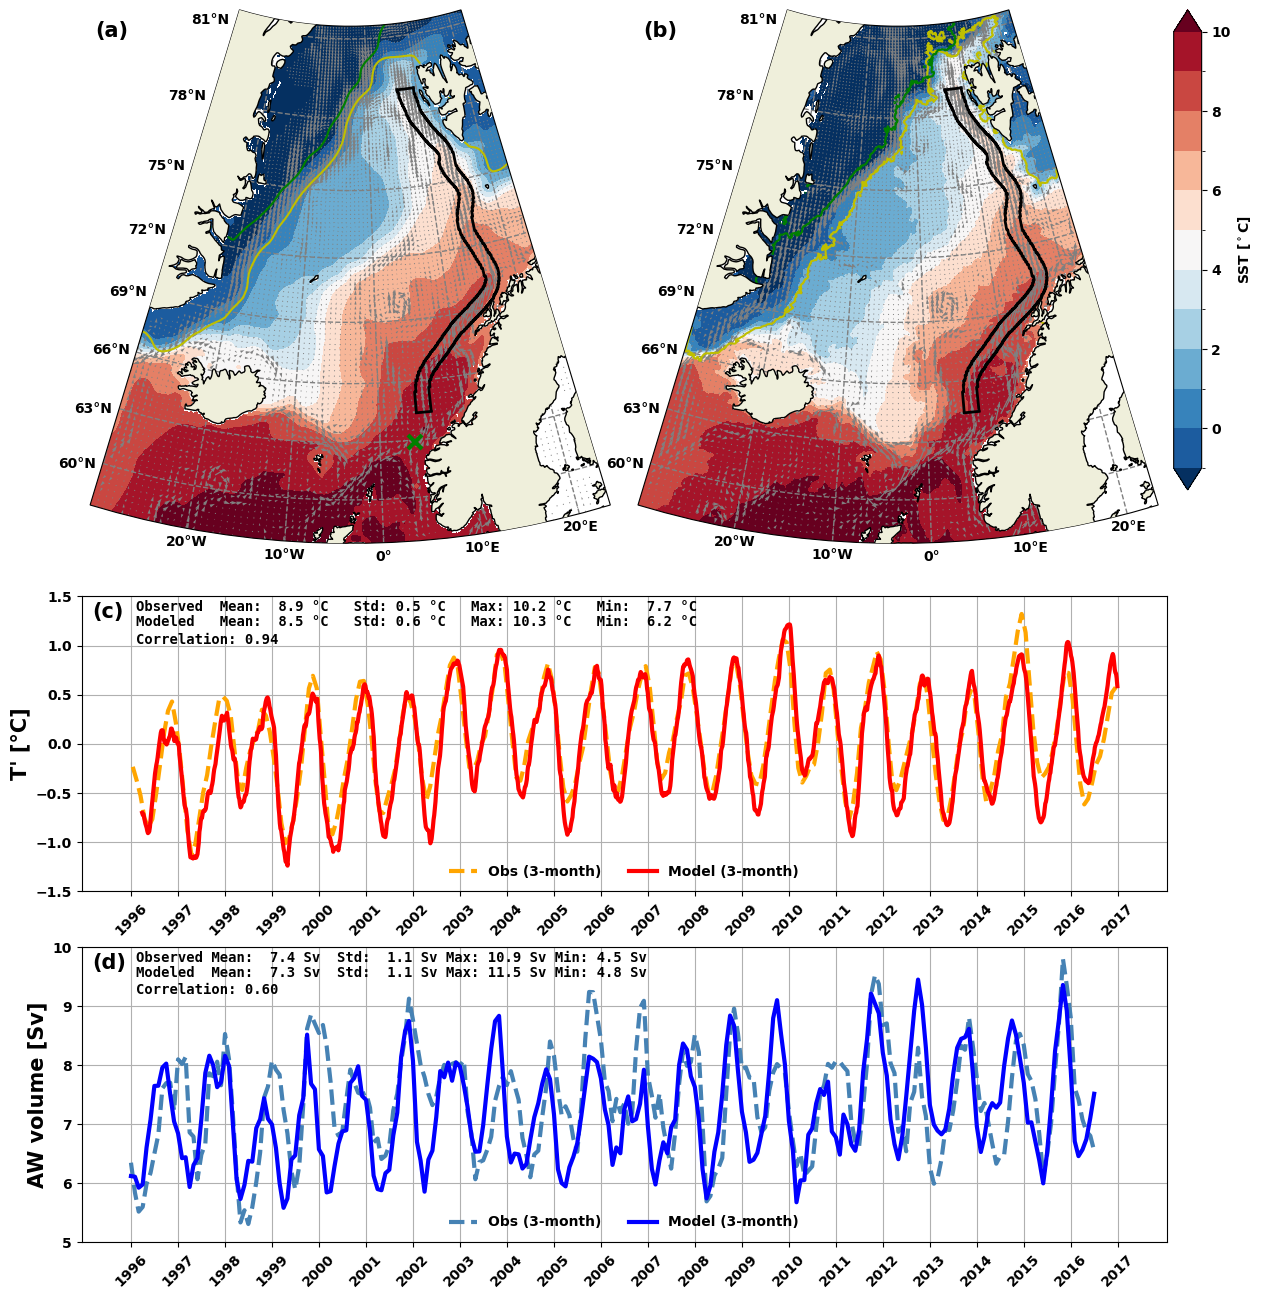

In [79]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy
import numpy as np
import matplotlib.path as mpath
import pandas as pd

n, lon1, lon2, lat1, lat2 = 20, -30, 23.25, 57.67, 81.45
proj = ccrs.LambertConformal(central_longitude=(lon2 + lon1) / 2, central_latitude=(lat2 + lat1) / 2)

fig = plt.figure(figsize=(14, 16),  )
gs = gridspec.GridSpec(3, 2, height_ratios=[1.8, 1, 1], hspace=0.15, wspace=0.02)

# Create axes
ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax2 = fig.add_subplot(gs[0, 1], projection=proj)
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :], sharex=ax3)

# Set up map features
for i, ax in enumerate([ax1, ax2]):
    ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
    aoi = mpath.Path(
        list(zip(np.linspace(lon1, lon2, n), np.full(n, lat2))) +
        list(zip(np.full(n, lon2), np.linspace(lat2, lat1, n))) +
        list(zip(np.linspace(lon2, lon1, n), np.full(n, lat1))) +
        list(zip(np.full(n, lon1), np.linspace(lat1, lat2, n)))
    )
    ax.set_boundary(aoi, transform=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, edgecolor='black', zorder=3)
    
    gl = ax.gridlines(draw_labels=True, rotate_labels=False, x_inline=False, y_inline=False,
                      color='gray', linewidth=1, alpha=1, linestyle="--")
    plt.draw()
    for ea in gl.ylabel_artists + gl.xlabel_artists:
        position = ea.get_position()
        if (ea in gl.ylabel_artists and position[0] > 0) or (ea in gl.xlabel_artists and position[1] > 0):
            ea.set_visible(False)

    ax.plot(south_face[:, 0], south_face[:, 1], transform=ccrs.PlateCarree(), color='k', linewidth=2)
    ax.plot(west_face[:, 0], west_face[:, 1], transform=ccrs.PlateCarree(), color='k', linewidth=2)
    ax.plot(east_face[:, 0], east_face[:, 1], transform=ccrs.PlateCarree(), color='k', linewidth=2)
    ax.plot(north_face[:, 0], north_face[:, 1], transform=ccrs.PlateCarree(), color='k', linewidth=2)

# SST plots
cax = satellite_sst.where(~baltic_mask).plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),
                                                      add_colorbar=False, cmap=plt.cm.RdBu_r, levels=np.arange(-1, 11, 1))
cax2 = model_sst.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),
                               add_colorbar=False, cmap=plt.cm.RdBu_r, levels=np.arange(-1, 11, 1))

# Colorbar
cbar_ax = fig.add_axes([0.905, 0.58, 0.02, 0.3])
cbar = fig.colorbar(cax2, cax=cbar_ax, extend='both')
cbar.set_label("SST [$^\circ$C]")

# Quiver overlay
x_spacing, y_spacing = 8, 8
X, Y = np.meshgrid(satellite_u.XC[::x_spacing].data, satellite_u.YC[::y_spacing].data)
u_vec = satellite_u[::y_spacing, ::x_spacing].where(abs(satellite_u[::y_spacing, ::x_spacing]) > 0)
v_vec = satellite_v[::y_spacing, ::x_spacing].where(abs(satellite_v[::y_spacing, ::x_spacing]) > 0)
ax1.quiver(X, Y, u_vec.data, v_vec.data, transform=ccrs.PlateCarree(), color='gray')
satellite_seaice[2].plot.contour(ax=ax1, transform=ccrs.PlateCarree(), levels=[0.3], colors='y')
satellite_seaice[8].plot.contour(ax=ax1, transform=ccrs.PlateCarree(), levels=[0.3], colors='g')
ax1.plot(4, 62.9, transform=ccrs.PlateCarree(), marker='x', markersize=10, color='g', alpha=1, markeredgewidth=3)


model_u=ug_avg.sel(time=sel_time).mean('time').compute()
model_v=vg_avg.sel(time=sel_time).mean('time').compute()
u_vec = model_u[::y_spacing, ::x_spacing].where(abs(model_u[::y_spacing, ::x_spacing]) > 0)
v_vec = model_v[::y_spacing, ::x_spacing].where(abs(model_v[::y_spacing, ::x_spacing]) > 0)
ax2.quiver(X, Y, u_vec.data, v_vec.data, transform=ccrs.PlateCarree(), color='gray')
model_seaice[2].plot.contour(ax=ax2, transform=ccrs.PlateCarree(), levels=[0.3], colors='y')
model_seaice[8].plot.contour(ax=ax2, transform=ccrs.PlateCarree(), levels=[0.3], colors='g')

ax1.set_title("")
ax2.set_title("")


# Time series plot (T anomaly)
ax3.plot(svinoy_t_3m_obs.x_axis_1, svinoy_t_3m_obs, label='Obs (3-month)', color='orange', lw=3, linestyle='--')
#ax3.plot(svinoy_t_3m_model.time, svinoy_t_3m_xx, label='Model (3-month)', color='r', lw=3)
ax3.plot(svinoy_t_3m_model.time, svinoy_t_3m, label='Model (3-month)', color='r', lw=3)

ax3.set_ylim(-1.5, 1.5)
ax3.set_ylabel("T' [°C]", fontsize=15)
ax3.legend(ncols=2, loc="lower center", framealpha=0.)
ax3.grid()

# Annotations
ax3.text(0.05, 0.95, "Observed  Mean:  8.9 °C   Std: 0.5 °C   Max: 10.2 °C   Min:  7.7 °C",
         fontsize=10, transform=ax3.transAxes, weight="bold", family="monospace")
ax3.text(0.05, 0.90, "Modeled   Mean:  8.5 °C   Std: 0.6 °C   Max: 10.3 °C   Min:  6.2 °C",
         fontsize=10, transform=ax3.transAxes, weight="bold", family="monospace")
ax3.text(0.05, 0.84, "Correlation: 0.94",
         fontsize=10, transform=ax3.transAxes, weight="bold", family="monospace")

# Time series plot (volume transport)
monthly_time_axis = pd.date_range(start='1996-01', end='2016-07', freq='MS')
ax4.plot(monthly_time_axis, obs_gsr_aw, label='Obs (3-month)', color='steelblue', lw=3, linestyle='--')
ax4.plot(monthly_time_axis, model_gsr_aw, label='Model (3-month)', color='b',lw=3)

ax4.set_ylabel("AW volume [Sv]", fontsize=15)
ax4.set_ylim(5, 10)
ax4.grid()
ax4.legend(ncols=2, loc="lower center", framealpha=0.)

# Annotations
ax4.text(0.05, 0.95, "Observed Mean:  7.4 Sv  Std:  1.1 Sv Max: 10.9 Sv Min: 4.5 Sv",
         fontsize=10, transform=ax4.transAxes, weight="bold", family="monospace")
ax4.text(0.05, 0.90, "Modeled  Mean:  7.3 Sv  Std:  1.1 Sv Max: 11.5 Sv Min: 4.8 Sv",
         fontsize=10, transform=ax4.transAxes, weight="bold", family="monospace")
ax4.text(0.05, 0.84, "Correlation: 0.60",
         fontsize=10, transform=ax4.transAxes, weight="bold", family="monospace")

# Final tweaks
for ax in [ax3, ax4]:
    ax.set_xticks(pd.date_range(start="1996-01", end="2017-12", freq='YS'))
    ax.set_xticklabels([str(year) for year in range(1996, 2018)], rotation=45, ha='center')
    ax.set_xlabel('')
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

for label, ax in zip(subplot_labels, [ax1,ax2,ax3, ax4]):
    ax.text(0.01, 0.98, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')
#plt.tight_layout()
plt.show()
fig.savefig('../Manuscript/FIGs/FIG2.png', bbox_inches='tight', transparent=True,dpi=500)




# FIG3

In [46]:
# Bugeting
# Seawater density (kg/m^3)
rhoconst = 1027
# Heat capacity (J/kg/K)
c_p = 3.986e3 # J/(kg·K)
# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0
Z = ds.Z#.compute()
RF = np.concatenate([ds.Zp1.values[:-1],[np.nan]])
#RF = ds.Zp1.values
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0
# Create xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.Z],dims=['Z'])
q2 = xr.DataArray(q2,coords=[Z.Z],dims=['Z'])
## Land masks
# Make copy of hFacC
mskC = ds.hFacC.copy(deep=True).compute()
# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(Z=-1)==1))*averages2D.oceQsw).transpose('Z', 'time','YC', 'XC')

forcH_surf = ((averages2D.TFLUX - (1-(q1[0]-q2[0]))*averages2D.oceQsw)\
              *mskC[0]).assign_coords(Z=forcH_subsurf.Z[0].values).expand_dims('Z')
forcH = xr.concat([forcH_surf,forcH_subsurf[1:,:,:]], dim='Z')
G_forcing = (forcH )/(rhoconst*c_p )/ (ds.hFacC*ds.drF)


vol = (ds.rA*ds.drF)* ds.hFacC
sTHETA = ds.T*(1+ds.Eta/ds.Depth).where(ds.hFacC != 0)
G_total = sTHETA.diff(dim='time')/5/86400

from matplotlib.path import Path
from shapely.geometry import Point
vertices = np.concatenate((west_face, north_face, east_face[::-1], south_face), axis=0)
path = Path(vertices)

lon_grid, lat_grid = np.meshgrid(ds.XC.values, ds.YC.values)  # Replace with actual grid data

# Flatten the grid arrays
lon_grid_flat = lon_grid.flatten()
lat_grid_flat = lat_grid.flatten()
points = np.vstack((lon_grid_flat, lat_grid_flat)).T


inside_boundary = path.contains_points(points)

# Step 4: Reshape the mask to the original grid shape
inside_boundary_grid = inside_boundary.reshape(lon_grid.shape)

inside_points = path.contains_points(points)
boundary_points = path.contains_points(points, radius=-1e-5)
inside_or_boundary = inside_points | boundary_points
# Step 4: Extract the coordinates of points within or on the boundary
lon_inside_boundary = lon_grid_flat[inside_or_boundary]
lat_inside_boundary = lat_grid_flat[inside_or_boundary]
# Result: Arrays of longitude and latitude of points within or on the boundary
all_boundary_points = np.vstack((lon_inside_boundary, lat_inside_boundary)).T

boundary_points_set = set(map(tuple, all_boundary_points))
# Step 2: Initialize the mask with the same shape as the grid
mask = np.zeros(lon_grid.shape, dtype=bool)

# Step 3: Check each point in the grid if it's in boundary_points_set
for i in range(lon_grid.shape[0]):
    for j in range(lon_grid.shape[1]):
        point = (lon_grid[i, j], lat_grid[i, j])
        if point in boundary_points_set:
            mask[i, j] = True

In [47]:
cp = 3986  # J/(kg·K)
rho0=1027  # kg/m3

West_wall_heat_trans= (west_mooring_way2.ADVx_TH * west_mooring_U_dir + west_mooring_way2.ADVy_TH * west_mooring_V_dir).sum(['Z','mooring']) * cp *rho0 * 1e-12
East_wall_heat_trans= (east_mooring_way2.ADVx_TH * east_mooring_U_dir *(-1) + east_mooring_way2.ADVy_TH * east_mooring_V_dir).sum(['Z','mooring']) * cp *rho0 * 1e-12
South_wall_heat_trans =   (mooring_south.ADVy_TH ).sum(['Z','mooring']) * cp *rho0 * 1e-12
North_wall_heat_trans =   (mooring_north.ADVy_TH ).sum(['Z','mooring']) * cp *rho0 * 1e-12
ATM=(G_forcing.where(mask) * cp * rho0 * ds.drF * ds.rA * 1e-12).sum(['Z','XC','YC'])
OHC_tendency = (G_total.where(mask)* cp * rho0 * ds.drF * ds.rA * 1e-12 ).sum(['XC','YC','Z'])#.mean().values


In [48]:
South_wall_heat_trans_values = South_wall_heat_trans.values
North_wall_heat_trans_values = North_wall_heat_trans.values
West_wall_heat_trans_values = West_wall_heat_trans.values
East_wall_heat_trans_values = East_wall_heat_trans.values
Heat_adv_values= South_wall_heat_trans_values - North_wall_heat_trans_values + West_wall_heat_trans_values + East_wall_heat_trans_values
ATM_values = ATM.values
OHC_tendency_values=OHC_tendency.values



In [49]:

# Exclude specific dates from the dataset
excluded_dates = [
    np.datetime64("2000-01-02"),
    np.datetime64("2006-01-05"),
    np.datetime64("2012-01-04")
]
time_xaxis = OHC_tendency.sel(time=~OHC_tendency.time.isin(excluded_dates)).time

# Indices to exclude from the data
excluded_indices = [291, 730, 1168]

# Define the datasets for plotting
heat_adv = np.delete(Heat_adv_values[1:], excluded_indices)
ohc_tendency = np.delete(OHC_tendency_values, excluded_indices)
air_sea_flux = np.delete(ATM_values[1:], excluded_indices)



In [50]:
residual = ohc_tendency - heat_adv - air_sea_flux

In [51]:
monthly_window_size = 6
three_monthly_window_size = 18
six_monthly_window_size = 36
yearly_window_size = 72
from scipy.ndimage import uniform_filter1d

window_size=yearly_window_size
Heat_adv_values_running = uniform_filter1d(heat_adv, size=window_size, mode='reflect')
OHC_tendency_values_running = uniform_filter1d(ohc_tendency, size=window_size, mode='reflect')
ATM_values_running = uniform_filter1d(air_sea_flux, size=window_size, mode='reflect')


In [52]:
# subplot 2 climatology
# remove the first time frame and restarting time frames

OHC_tendency_chosen= OHC_tendency.sel(time=~((OHC_tendency.time == np.datetime64("2000-01-02")) | (OHC_tendency.time == np.datetime64("2006-01-05"))| (OHC_tendency.time == np.datetime64("2012-01-04"))  ))
Heat_convergence = South_wall_heat_trans - North_wall_heat_trans + West_wall_heat_trans + East_wall_heat_trans
Heat_convergence_chosen = Heat_convergence.sel(time=~((Heat_convergence.time == np.datetime64("2000-01-02")) | (Heat_convergence.time == np.datetime64("2006-01-05"))| (Heat_convergence.time == np.datetime64("2012-01-04"))  ))
Heat_convergence_chosen = Heat_convergence_chosen[1:]
ATM_chosen = ATM.sel(time=~((ATM.time == np.datetime64("2000-01-02")) | (ATM.time == np.datetime64("2006-01-05"))| (ATM.time == np.datetime64("2012-01-04"))  ))


advective_heat_convergence = Heat_convergence_chosen.resample(time='1MS').mean().groupby('time.month').mean('time').values
advective_heat_convergence_std = Heat_convergence_chosen.resample(time='1MS').mean().groupby('time.month').std('time').values

heat_content_tendency = OHC_tendency_chosen.resample(time='1MS').mean().groupby('time.month').mean('time').values
heat_content_tendency_std = OHC_tendency_chosen.resample(time='1MS').mean().groupby('time.month').std('time').values

air_sea_flux_clim = ATM_chosen.resample(time='1MS').mean().groupby('time.month').mean('time').values
air_sea_flux_std = ATM_chosen.resample(time='1MS').mean().groupby('time.month').std('time').values


advective_heat_convergence = np.append(advective_heat_convergence, advective_heat_convergence[0])
advective_heat_convergence_std = np.append(advective_heat_convergence_std, advective_heat_convergence_std[0])

heat_content_tendency = np.append(heat_content_tendency, heat_content_tendency[0])
heat_content_tendency_std = np.append(heat_content_tendency_std, heat_content_tendency_std[0])

air_sea_flux_clim = np.append(air_sea_flux_clim, air_sea_flux_clim[0])
air_sea_flux_std = np.append(air_sea_flux_std, air_sea_flux_std[0])

lower_bound1 = advective_heat_convergence - advective_heat_convergence_std
upper_bound1 = advective_heat_convergence + advective_heat_convergence_std

lower_bound2 = heat_content_tendency - heat_content_tendency_std
upper_bound2 = heat_content_tendency + heat_content_tendency_std

lower_bound3 = air_sea_flux_clim - air_sea_flux_std
upper_bound3 = air_sea_flux_clim + air_sea_flux_std

In [53]:

window_size=yearly_window_size
South_wall_heat_trans_values_1y_running = uniform_filter1d(np.delete(South_wall_heat_trans_values[1:], [291, 730, 1168]), size=window_size, mode='reflect')
North_wall_heat_trans_values_1y_running = uniform_filter1d(np.delete(North_wall_heat_trans_values[1:], [291, 730, 1168]), size=window_size, mode='reflect')
West_wall_heat_trans_values_1y_running = uniform_filter1d(np.delete(West_wall_heat_trans_values[1:], [291, 730, 1168]), size=window_size, mode='reflect')
East_wall_heat_trans_values_1y_running = uniform_filter1d(np.delete(East_wall_heat_trans_values[1:], [291, 730, 1168]), size=window_size, mode='reflect')

advective_heat_conv = uniform_filter1d(np.delete(Heat_adv_values[1:], [291, 730, 1168]), size= window_size, mode='reflect')





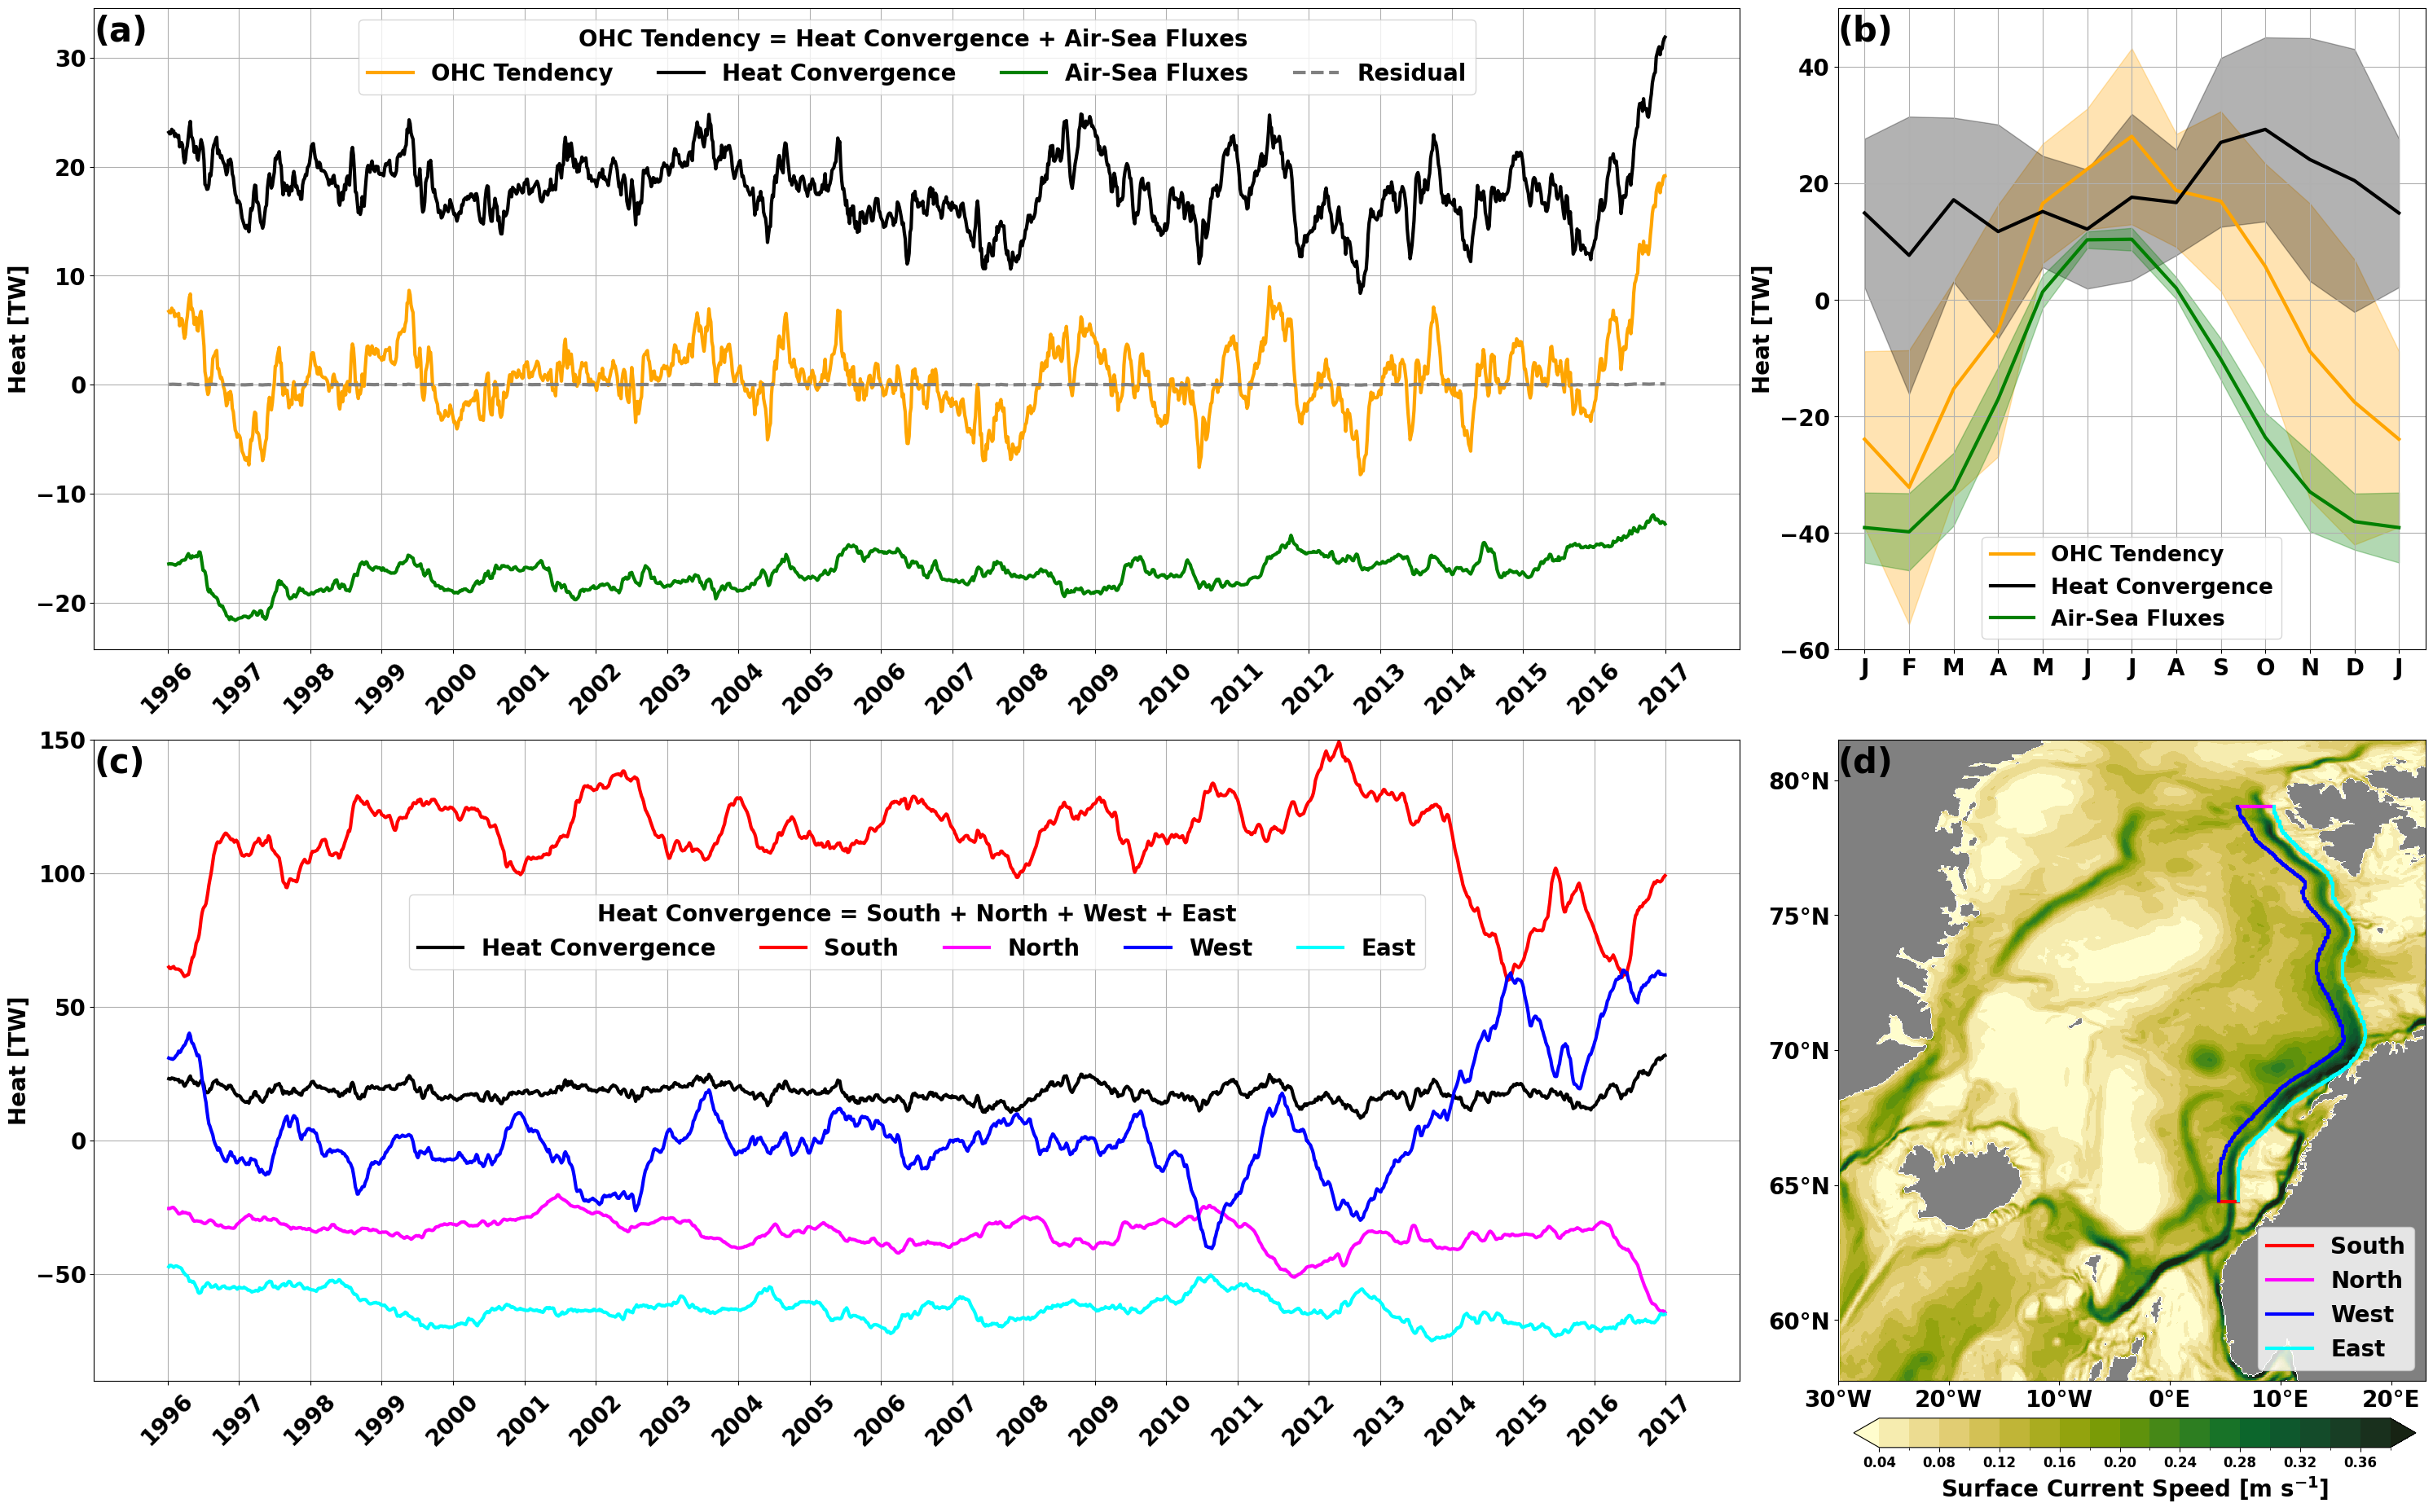

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import cmocean

# Define a consistent color scheme
colors = {
    'Advective Heat Convergence': 'k',
    'Ocean Heat Content Tendency': 'orange',
    'Air-Sea Fluxes': 'green',
    'Residual': '#808080',
    'South': 'red',  # Blue Violet
    'North': 'magenta',  # Hot Pink
    'West': 'blue',   # Light Sea Green
    'East': 'cyan',   # Orange Red #FF69B4
    'Heat Convergence': 'blue'
}

# Define a consistent font size
label_fontsize = 20
label_fontsize_order = 25

# Create the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(30, 18), width_ratios=[2.8, 1])
labels = ["(a)", "(b)", "(c)", "(d)"]

# Add labels to each subplot
for ax, label in zip(axes.flatten(), labels):
    ax.text(0, 0.99, label, fontsize=30, va='top', ha='left', weight="bold", transform=ax.transAxes)

# Subplot 1: Budget Closure
ax1 = axes.flatten()[0]
ax1.plot(time_xaxis, OHC_tendency_values_running, label='OHC Tendency', lw=3, linestyle='-', color=colors['Ocean Heat Content Tendency'])
ax1.plot(time_xaxis, Heat_adv_values_running, label='Heat Convergence', lw=3, linestyle='-', color=colors['Advective Heat Convergence'])
ax1.plot(time_xaxis, ATM_values_running, label='Air-Sea Fluxes', lw=3, linestyle='-', color=colors['Air-Sea Fluxes'])
residual_running = uniform_filter1d(residual, size=window_size, mode='reflect')

ax1.plot(time_xaxis, residual_running, label='Residual', lw=3, linestyle='--', color=colors['Residual'])


# Customize legend and grid
ax1.legend(title="OHC Tendency = Heat Convergence + Air-Sea Fluxes ",
           title_fontsize=label_fontsize, fontsize=label_fontsize, ncols=4, loc='upper center', )# prop=dict(weight='bold')
ax1.grid()


# Set axis labels and ticks
ax1.set_ylabel('Heat [TW]', fontsize=label_fontsize)
ax1.set_xticks(pd.date_range(start="1996-01-01", end="2017-12-31", freq='YS'))
ax1.set_xticklabels([str(year) for year in range(1996, 2018)], rotation=45, fontsize=label_fontsize)
ax1.tick_params(axis='y', labelsize=label_fontsize)
ax1.tick_params(axis='x', labelsize=label_fontsize)

# Subplot 2: Monthly Climatology
ax2 = axes.flatten()[1]
def plot_with_shading(ax, xaxis, data_line, lower_bound, upper_bound, label, color):
    """Plot a line and shaded region with the given data and bounds."""
    ax.plot(xaxis, data_line, label=label, lw=3, linestyle='-', color=color)
    ax.fill_between(xaxis, lower_bound, upper_bound, color=color, alpha=0.3)
xaxis_months = np.arange(1, 14)
plot_with_shading(ax2, xaxis_months, heat_content_tendency, lower_bound2, upper_bound2, 'OHC Tendency', colors['Ocean Heat Content Tendency'])
plot_with_shading(ax2, xaxis_months, advective_heat_convergence, lower_bound1, upper_bound1, 'Heat Convergence', colors['Advective Heat Convergence'])
plot_with_shading(ax2, xaxis_months, air_sea_flux_clim, lower_bound3, upper_bound3, 'Air-Sea Fluxes', colors['Air-Sea Fluxes'])

# Customize x-ticks to represent months
ax2.set_xticks(range(1, 14))
#ax2.set_xticklabels([str(i) for i in range(1, 13)])

ax2.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D", "J"])

# Add a legend to the plot
ax2.legend(fontsize=19, loc='lower center',)

# Set grid, axis labels, and tick parameters
ax2.grid(True)
ax2.tick_params(axis='x', labelsize=label_fontsize)
ax2.tick_params(axis='y', labelsize=label_fontsize)
ax2.set_ylabel('Heat [TW]', fontsize=label_fontsize)

ax2.set_ylim(-60,)




# Subplot 3: Heat Convergence
ax3 = axes.flatten()[2]
ax3.plot(time_xaxis, advective_heat_conv, label='Heat Convergence', lw=3, linestyle='-', color=colors['Advective Heat Convergence'])
ax3.plot(time_xaxis, South_wall_heat_trans_values_1y_running, label='South', lw=3, linestyle='-', color=colors['South'])
ax3.plot(time_xaxis, -North_wall_heat_trans_values_1y_running, label='North', lw=3, linestyle='-', color=colors['North'])
ax3.plot(time_xaxis, West_wall_heat_trans_values_1y_running, label='West', lw=3, linestyle='-', color=colors['West'])
ax3.plot(time_xaxis, East_wall_heat_trans_values_1y_running, label='East', lw=3, linestyle='-', color=colors['East'])

# Set y-axis limits
ax3.set_ylim(-90, 150)
# Customize legend and grid
ax3.legend(
    title="Heat Convergence = South + North + West + East",
    title_fontsize=20, fontsize=20, ncols=5, loc='center', bbox_to_anchor=(0.5, 0.7)

)
ax3.grid()

# Set axis labels and ticks
ax3.set_ylabel('Heat [TW]', fontsize=label_fontsize)
ax3.set_xticks(pd.date_range(start="1996-01-01", end="2017-12-31", freq='YS'))
ax3.set_xticklabels([str(year) for year in range(1996, 2018)], rotation=45, fontsize=label_fontsize)
ax3.tick_params(axis='x', labelsize=label_fontsize)
ax3.tick_params(axis='y', labelsize=label_fontsize)

# Subplot 4: 'Worm' Domain
ds.maskInC.where(ds.maskInC == 0).plot(ax=axes.flatten()[3], cmap='gray', add_colorbar=False)
surface_geo_vel = geo_avg.mean('time').compute()
p4= surface_geo_vel[2:,:-2].plot(ax=axes.flatten()[3],robust=True,add_colorbar=False,  cmap=cmocean.cm.speed,vmin=0.04,vmax=0.38, levels=np.arange(0.04,0.4, 0.02),
                        #cbar_kwargs={'orientation': 'horizontal', 'label': 'Surface velocity [m/s]', 'shrink': 1, 'pad': 0.07,}
                        )

# Plot boundary faces (south, west, east, north)
def plot_faces(ax, south_face, west_face, east_face, north_face):
    """Plot boundary faces on the given axis."""
    # Plot each face (South, West, East, North) with appropriate colors and labels

    ax.plot(south_face[:, 0], south_face[:, 1], color=colors['South'], linestyle='-', linewidth=3, label="South")
    ax.plot(north_face[:, 0], north_face[:, 1], color=colors['North'], linestyle='-', linewidth=3, label='North')
    ax.plot(west_face[:, 0], west_face[:, 1], color=colors['West'], linestyle='-', linewidth=3, label='West')
    ax.plot(east_face[:, 0], east_face[:, 1], color=colors['East'], linestyle='-', linewidth=3, label='East')
plot_faces(axes.flatten()[3], south_face, west_face, east_face, north_face)

axes.flatten()[3].set_ylabel("")  # Optionally add a y-label here
axes.flatten()[3].set_xlabel("")
# Optionally customize the tick labels to show degrees with N/W
axes.flatten()[3].set_xticks(np.arange(-30, 30, 10))  # Adjust tick range as needed
axes.flatten()[3].set_yticks(np.arange(60, 85, 5))    # Adjust tick range as needed
axes.flatten()[3].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{abs(x)}°{'W' if x < 0 else 'E'}"))
axes.flatten()[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{abs(y)}°{'S' if y < 0 else 'N'}"))
axes.flatten()[3].set_title("")
axes.flatten()[3].tick_params(axis='x', labelsize=label_fontsize)
axes.flatten()[3].tick_params(axis='y', labelsize=label_fontsize)
axes.flatten()[3].legend(fontsize=label_fontsize, ncols=1, loc='lower right')
# Create a custom axes for the colorbar (position: [left, bottom, width, height])
cbar_ax = fig.add_axes([0.76, 0.01, 0.23, 0.02])  # Adjust these values for exact placement
cbar = fig.colorbar(p4, cax=cbar_ax, orientation='horizontal', extend='both',label= r'Surface Current Speed [m s$^{-1}$]',)
cbar.set_label(r'Surface Current Speed [m s$^{-1}$]', fontsize=20)
cbar.ax.tick_params(labelsize=12) 
# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig('../Manuscript/FIGs/FIG3.png', bbox_inches='tight', transparent=True,dpi=500)



# FIG4

In [55]:
x_spacing, y_spacing=8, 8
XC_extend=slice(-6,20)
YC_extend=slice(60,80)
indices_for_lines = [(327, 329), (680, 657)]
def plot_faces(ax, south_face, west_face, east_face, north_face):
    """Plot boundary faces on the given axis."""
    # Plot each face (South, West, East, North) with appropriate colors and labels
    ax.plot(south_face[:, 0], south_face[:, 1], color='k', linestyle='-', linewidth=3, label="South")
    ax.plot(west_face[:, 0], west_face[:, 1], color='k', linestyle='-', linewidth=3, label='West')
    ax.plot(east_face[:, 0], east_face[:, 1], color='k', linestyle='-', linewidth=3, label='East')
    ax.plot(north_face[:, 0], north_face[:, 1], color='k', linestyle='-', linewidth=3, label='North')
    ax.plot(4.4166665,64.42213, 'o', markersize=10,color='k',)
    ax.plot(15.75,70.4921, 'o', markersize=10,color='k',)
    ax.plot(11.083333,76.58879, 'o', markersize=10,color='k',)
    ax.plot(6.0833335, 79.01265,'o', markersize=10,color='k',)
    ax.plot(south_face[-1, 0],south_face[0, 1], 'o', markersize=10,color='k',)
    ax.plot(north_face[-1, 0],north_face[0, 1], 'o', markersize=10,color='k',)
    ax.plot(14.083333, 76.58879, 'o', markersize=10,color='k',)
    ax.plot(17.666666, 70.4921,'o', markersize=10,color='k',)
def plot_diagonal_lines(ax, west_face, east_face, indices):
    """Plot diagonal lines connecting the west and east faces."""
    for idx_w, idx_e in indices:
        ax.plot([west_face[idx_w][0], east_face[idx_e][0]],
                [west_face[idx_w][1], east_face[idx_e][1]],
                linestyle='-', linewidth=3, color='k')




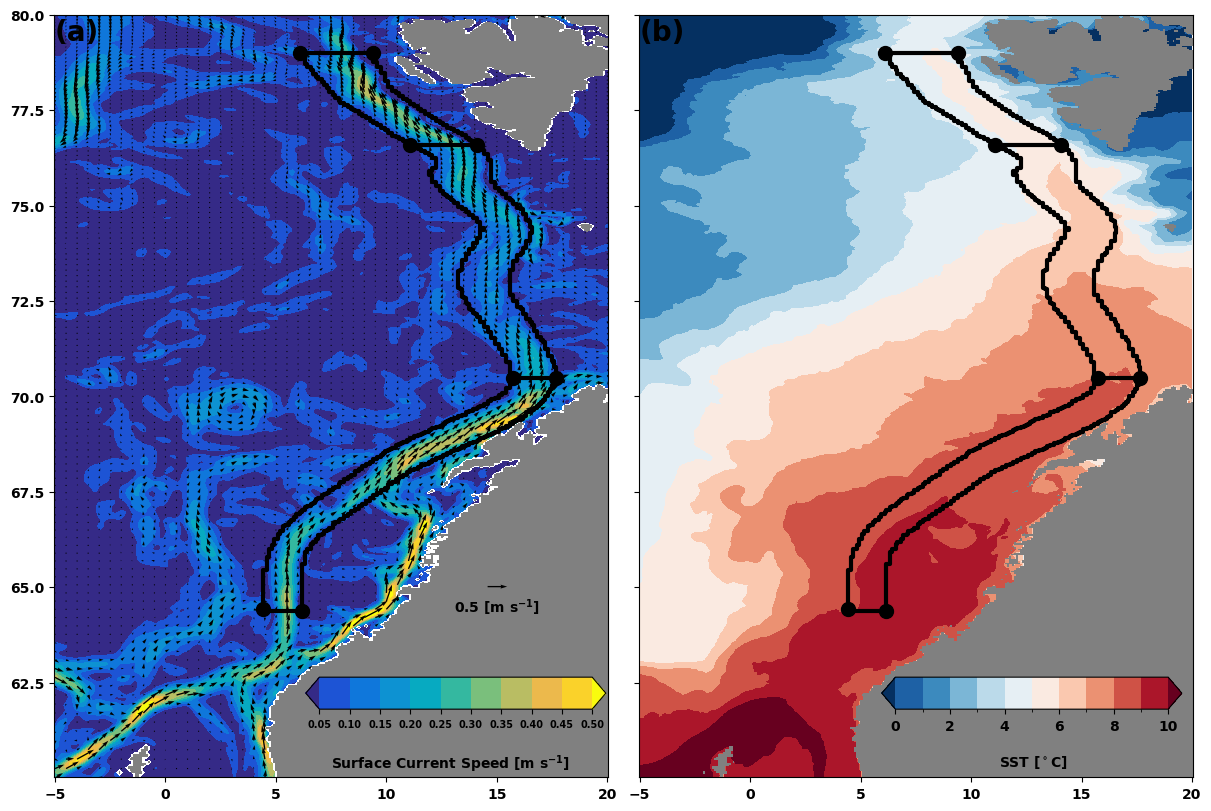

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8), layout='constrained', sharey=True, sharex=True)

XC_extend=slice(-5,20)
YC_extend=slice(60,80)  


sel_time=slice('2011-01-01','2011-12-31')
u=ug_avg.sel(time=sel_time).mean('time')
v=vg_avg.sel(time=sel_time).mean('time')

spd = np.sqrt(u**2 + v**2)
cax=spd.sel(XC=XC_extend, YC=YC_extend).plot.contourf(
    ax=axes[0],cmap=parula,add_colorbar=False,levels=np.linspace(0.05,0.5,10),)


# cmap = matplotlib.cm.get_cmap("RdBu_r").copy()
# cmap.set_bad(color='gray')


cax2=ds.T[:,0].sel(XC=XC_extend, YC=YC_extend, time=slice('2011-01-01','2011-12-31')).mean('time').plot.contourf(
    ax=axes[1], robust=True, cmap=plt.cm.RdBu_r, levels=np.arange(0,11,1),add_colorbar=False,
)

axes[0].text(-5, 79.9, "(a)", fontsize=20, va='top',ma='left', weight="bold", )
axes[1].text(-5, 79.9, "(b)", fontsize=20, va='top',ma='left', weight="bold", )

for ax in axes.flatten():#
    ds.maskInC.where(ds.maskInC==0).sel(XC=XC_extend, YC=YC_extend).plot(ax=ax, cmap='gray',add_colorbar=False,)
    plot_diagonal_lines(ax, west_face, east_face, indices_for_lines) 
    plot_faces(ax, south_face, west_face, east_face, north_face)
    ax.set_title("")
    ax.set_ylabel("")
    ax.set_xlabel("")

x_spacing, y_spacing=6, 6
X,Y=np.meshgrid(u.XC[::x_spacing].data,u.YC[::y_spacing].data)
u_vec=u[::y_spacing,::x_spacing].where(abs(u[::y_spacing,::x_spacing]) > 0)
v_vec=v[::y_spacing,::x_spacing].where(abs(v[::y_spacing,::x_spacing]) > 0)
Q=axes[0].quiver(X,Y, u_vec.data, v_vec.data, color='k', scale=None)
axes[0].quiverkey(Q, X=0.8, Y=0.25, U=0.5, label="0.5 [m s$^{-1}$]", labelpos='S')

# Create a custom axes for the colorbar (position: [left, bottom, width, height])
cbar_ax = fig.add_axes([0.25, 0.12, 0.25, 0.04])  # Adjust these values for exact placement
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
text = axes[0].text(0.5, 0.012, "Surface Current Speed [m s$^{-1}$] ", fontsize=10, color='k', transform=axes[0].transAxes)
cbar.ax.tick_params(labelsize=7) 


cbar_ax2 = fig.add_axes([0.73, 0.12, 0.25, 0.04])  # Adjust these values for exact placement
cbar = fig.colorbar(cax2, cax=cbar_ax2, orientation='horizontal', extend='both')
text = axes[1].text(0.65, 0.015, "SST [$^\circ$C] ", fontsize=10, color='k', transform=axes[1].transAxes)
#plt.tight_layout()

plt.show()
fig.savefig('../Manuscript/FIGs/FIG4.png', bbox_inches='tight', transparent=True,dpi=500)


# FIG5

In [57]:
##  raw data: theta, U, V  :
def CAL_REYNOLD_DECOM():
    THETA = ds.THETA  #* west_mooring_U_dir
    SALT=averages3D.SALT
    Vtransport = ds.VVELMASS  #* ds.dxG * ds.drF# 
    Utransport = ds.UVELMASS # * ds.dyG * ds.drF# 
    THETA = THETA.sel(time=~((THETA.time == np.datetime64("2000-01-02")) | (THETA.time == np.datetime64("2006-01-05"))| (THETA.time == np.datetime64("2012-01-04"))))
    SALT = SALT.sel(time=~((SALT.time == np.datetime64("2000-01-02")) | (SALT.time == np.datetime64("2006-01-05"))| (SALT.time == np.datetime64("2012-01-04"))))

    Vtransport = Vtransport.sel(time=~((Vtransport.time == np.datetime64("2000-01-02")) | (Vtransport.time == np.datetime64("2006-01-05"))|(Vtransport.time == np.datetime64("2012-01-04"))))
    Utransport = Utransport.sel(time=~((Utransport.time == np.datetime64("2000-01-02")) | (Utransport.time == np.datetime64("2006-01-05"))|(Utransport.time == np.datetime64("2012-01-04"))))

# Step 1: Calculate the seasonal climatologies
    U_clim = Utransport.groupby("time.season").mean("time")
    V_clim = Vtransport.groupby("time.season").mean("time")
    THETA_clim = THETA.groupby("time.season").mean("time")
    SALT_clim=SALT.groupby("time.season").mean("time")

# Step 2: Calculate anomalies relavtive to  seasonal climatologies
    U_anom = Utransport.groupby("time.season") - U_clim
    V_anom = Vtransport.groupby("time.season") - V_clim
    THETA_anom = THETA.groupby("time.season") - THETA_clim
    SALT_anom = SALT.groupby("time.season") - SALT_clim

    Vtransport_cgrid = grid.interp(Vtransport,'Y')
    Utransport_cgrid = grid.interp(Utransport,'X')
    
    V_clim_cgrid = grid.interp(V_clim,'Y')
    U_clim_cgrid = grid.interp(U_clim,'X')
    V_anom_cgrid = grid.interp(V_anom,'Y')
    U_anom_cgrid = grid.interp(U_anom,'X')   
    
# Step 3: Calculate derived variables
    HEATFLUX_tot =  (Vtransport_cgrid * THETA  + Utransport_cgrid *  THETA )#* cp *rho0 * 1e-12  #.sum(['Z','mooring']) * cp *rho0 * 1e-12
    HEATFLUX_tot_u =  (Utransport_cgrid *  THETA )#* cp *rho0 * 1e-12
    HEATFLUX_tot_v =  (Vtransport_cgrid * THETA  )#* cp *rho0 * 1e-12

# Cal mean    
    HEATFLUX_CLI_MEAN_u = Utransport_cgrid.mean('time') * THETA.mean('time') #* cp *rho0 * 1e-12
    HEATFLUX_CLI_MEAN_v = Vtransport_cgrid.mean('time') * THETA.mean('time') #* cp *rho0 * 1e-12
    HEATFLUX_CLI_MEAN_convergence = HEATFLUX_CLI_MEAN_u + HEATFLUX_CLI_MEAN_v
    
    HEATFLUX_SEASON_mean_u = (U_clim_cgrid * THETA_clim ) #* cp *rho0 * 1e-12
    HEATFLUX_SEASON_mean_v = (V_clim_cgrid  * THETA_clim ) #* cp *rho0 * 1e-12
    HEATFLUX_SEASON_mean_convergence = HEATFLUX_SEASON_mean_u + HEATFLUX_SEASON_mean_v

    #HEATFLUX_anom = HEATFLUX_tot.groupby('time.season')- HEATFLUX_SEASON_mean
    
        ## cal eddy
    HEATFLUX_eddy = (V_anom_cgrid * THETA_anom  +  U_anom_cgrid * THETA_anom) #* cp *rho0 * 1e-12
    HEATFLUX_eddy_u = ( U_anom_cgrid * THETA_anom) #* cp *rho0 * 1e-12
    HEATFLUX_eddy_v = (V_anom_cgrid * THETA_anom  ) #* cp *rho0 * 1e-12

    HEATFLUX_theta_driven =  (THETA_anom.groupby('time.season') * V_clim_cgrid   + THETA_anom.groupby('time.season') * U_clim_cgrid  ) #* cp *rho0 * 1e-12
    HEATFLUX_volume_driven =  (V_anom_cgrid.groupby('time.season') * THETA_clim  + U_anom_cgrid.groupby('time.season')  * THETA_clim ) #* cp *rho0 * 1e-12


# Step 3: Create a new Dataset with simplified names
    REYNOLD_DECOM = xr.Dataset({
        "U": Utransport,
        "U_clim": U_clim,
        "U_anom": U_anom,
        "U_anom_cgrid":U_anom_cgrid,
        
        "V": Vtransport,
        "V_clim": V_clim,
        "V_anom": V_anom,
        "V_anom_cgrid":V_anom_cgrid,
        
        "THETA": THETA,
        "THETA_clim": THETA_clim,
        "THETA_anom": THETA_anom,
        "HEATFLUX_tot": HEATFLUX_tot,
        
       # "HEATFLUX_mean": HEATFLUX_mean,
        "HEATFLUX_CLI_MEAN_convergence": HEATFLUX_CLI_MEAN_convergence,
        "HEATFLUX_CLI_MEAN_u": HEATFLUX_CLI_MEAN_u,
        "HEATFLUX_CLI_MEAN_v": HEATFLUX_CLI_MEAN_v,

        "HEATFLUX_SEASON_mean_convergence": HEATFLUX_SEASON_mean_convergence,
        "HEATFLUX_SEASON_mean_u":HEATFLUX_SEASON_mean_u,
        "HEATFLUX_SEASON_mean_v":HEATFLUX_SEASON_mean_v,
       
        #"HEATFLUX_anom":HEATFLUX_anom,
        "HEATFLUX_eddy": HEATFLUX_eddy,  
        "HEATFLUX_eddy_u": HEATFLUX_eddy_u, 
        "HEATFLUX_eddy_v": HEATFLUX_eddy_v, 
        "HEATFLUX_theta_driven": HEATFLUX_theta_driven,
        "HEATFLUX_volume_driven": HEATFLUX_volume_driven,
        
    })
    
    # Display the new dataset structure
    return REYNOLD_DECOM
REYNOLD_DECOM =  CAL_REYNOLD_DECOM()

In [58]:
%%time
mean_heat_flux_u_vec, mean_heat_flux_v_vec = REYNOLD_DECOM.HEATFLUX_CLI_MEAN_u.sel(Z=slice(None,-1000)).where(ds.maskInC).compute(),\
                                             REYNOLD_DECOM.HEATFLUX_CLI_MEAN_v.sel(Z=slice(None,-1000)).where(ds.maskInC).compute()

eddy_heat_flux_u_vec, eddy_heat_flux_v_vec = REYNOLD_DECOM.HEATFLUX_eddy_u.sel(Z=slice(None,-1000)).mean('time').where(ds.maskInC).compute(),\
                                             REYNOLD_DECOM.HEATFLUX_eddy_v.sel(Z=slice(None,-1000)).mean('time').where(ds.maskInC).compute()


CPU times: user 4h 19min 32s, sys: 2h 52min 41s, total: 7h 12min 14s
Wall time: 13min 43s


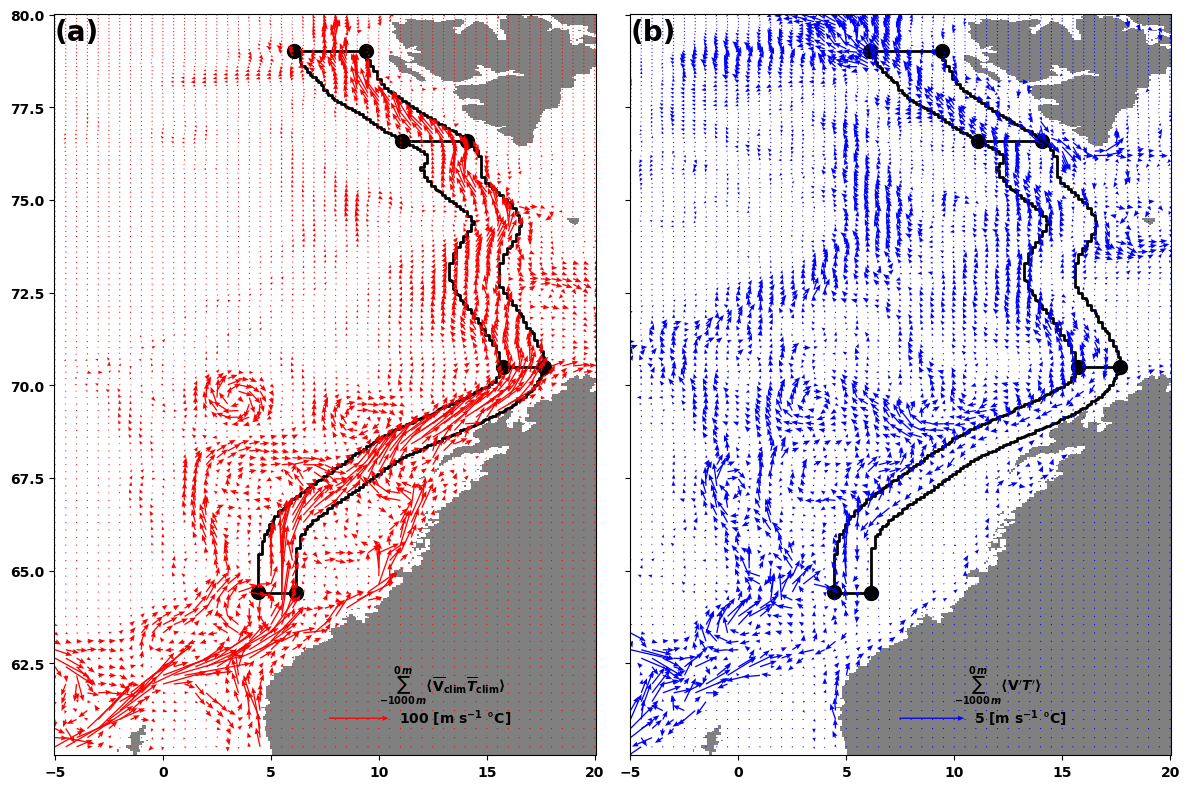

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), layout='constrained', sharey=True, sharex=True)

x_spacing, y_spacing=6, 6
XC_extend=slice(-5,20)
YC_extend=slice(60,80)

X,Y=np.meshgrid(mean_heat_flux_u_vec.XC[::x_spacing].sel(XC=XC_extend).data, \
                mean_heat_flux_u_vec.YC[::y_spacing].sel(YC=YC_extend).data)
u,v= mean_heat_flux_u_vec.sum(axis=0)[::x_spacing,::y_spacing].sel(XC=XC_extend,YC=YC_extend), \
    mean_heat_flux_v_vec.sum(axis=0)[::x_spacing,::y_spacing].sel(XC=XC_extend,YC=YC_extend)

u1,v1= eddy_heat_flux_u_vec.sum(axis=0)[::x_spacing,::y_spacing].sel(XC=XC_extend,YC=YC_extend), \
    eddy_heat_flux_v_vec.sum(axis=0)[::x_spacing,::y_spacing].sel(XC=XC_extend,YC=YC_extend)

linewidth=2
def plot_faces(ax, south_face, west_face, east_face, north_face):
    """Plot boundary faces on the given axis."""
    # Plot each face (South, West, East, North) with appropriate colors and labels
    ax.plot(south_face[:, 0], south_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label="South")
    ax.plot(west_face[:, 0], west_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='West')
    ax.plot(east_face[:, 0], east_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='East')
    ax.plot(north_face[:, 0], north_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='North')
    ax.plot(4.4166665,64.42213, 'o', markersize=10,color='k',)
    ax.plot(15.75,70.4921, 'o', markersize=10,color='k',)
    ax.plot(11.083333,76.58879, 'o', markersize=10,color='k',)
    ax.plot(6.0833335, 79.01265,'o', markersize=10,color='k',)
    ax.plot(south_face[-1, 0],south_face[0, 1], 'o', markersize=10,color='k',)
    ax.plot(north_face[-1, 0],north_face[0, 1], 'o', markersize=10,color='k',)
    ax.plot(14.083333, 76.58879, 'o', markersize=10,color='k',)
    ax.plot(17.666666, 70.4921,'o', markersize=10,color='k',)
def plot_diagonal_lines(ax, west_face, east_face, indices):
    """Plot diagonal lines connecting the west and east faces."""
    for idx_w, idx_e in indices:
        ax.plot([west_face[idx_w][0], east_face[idx_e][0]],
                [west_face[idx_w][1], east_face[idx_e][1]],
                linestyle='-', linewidth=linewidth, color='k')
for axes in ax:
    ds.maskInC.where(ds.maskInC==0).sel(XC=XC_extend, YC=YC_extend).plot(ax=axes, cmap='gray',add_colorbar=False,)
    axes.set_title("")
    axes.set_ylabel("")
    axes.set_xlabel("")
    plot_faces(axes, south_face, west_face, east_face, north_face)
    plot_diagonal_lines(axes, west_face, east_face, indices_for_lines)

Q1=ax[0].quiver(X,Y,u,v,  color='r', scale=None,zorder=2, headwidth =4)
Q2=ax[1].quiver(X,Y,u1,v1,  color='b', scale=None,zorder=2, headwidth =4)

text1 = (r"$\sum_{-1000\,m}^{0\,m}\langle\overline{\boldsymbol{\mathbf{V}}}_{\mathrm{clim}} \overline{T}_{\mathrm{clim}}\rangle$")

ax[0].text(10, 62.5, text1, fontsize=10, va='top',ma='left',  )
text2 = (r"$\sum_{-1000\,m}^{0\,m} \langle \mathbf{V}'T'  \rangle$")
ax[1].text(10, 62.5, text2, fontsize=10, va='top',ma='left',  )


ax[0].quiverkey(Q1, X=0.618, Y=0.05, U=100, label=  r"100 [m s$^{-1}$ °C]", labelpos='E')
ax[1].quiverkey(Q2, X=0.618, Y=0.05, U=5, label=r"5 [m s$^{-1}$ °C]", labelpos='E')
ax[0].text(-5, 79.9, "(a)", fontsize=20, va='top',ma='left', weight="bold", )
ax[1].text(-5, 79.9, "(b)", fontsize=20, va='top',ma='left', weight="bold", )

# ax[1].plot([11.083333, 14.083333], [76.58879,76.58879],  color='r', linestyle='-', linewidth=3,)
# ax[1].plot([15.75,17.666666], [70.4921,70.4921],  color='r', linestyle='-', linewidth=3,)
plt.tight_layout()
plt.show()
fig.savefig('../Manuscript/FIGs/FIG5.png', bbox_inches='tight', transparent=True,dpi=500)



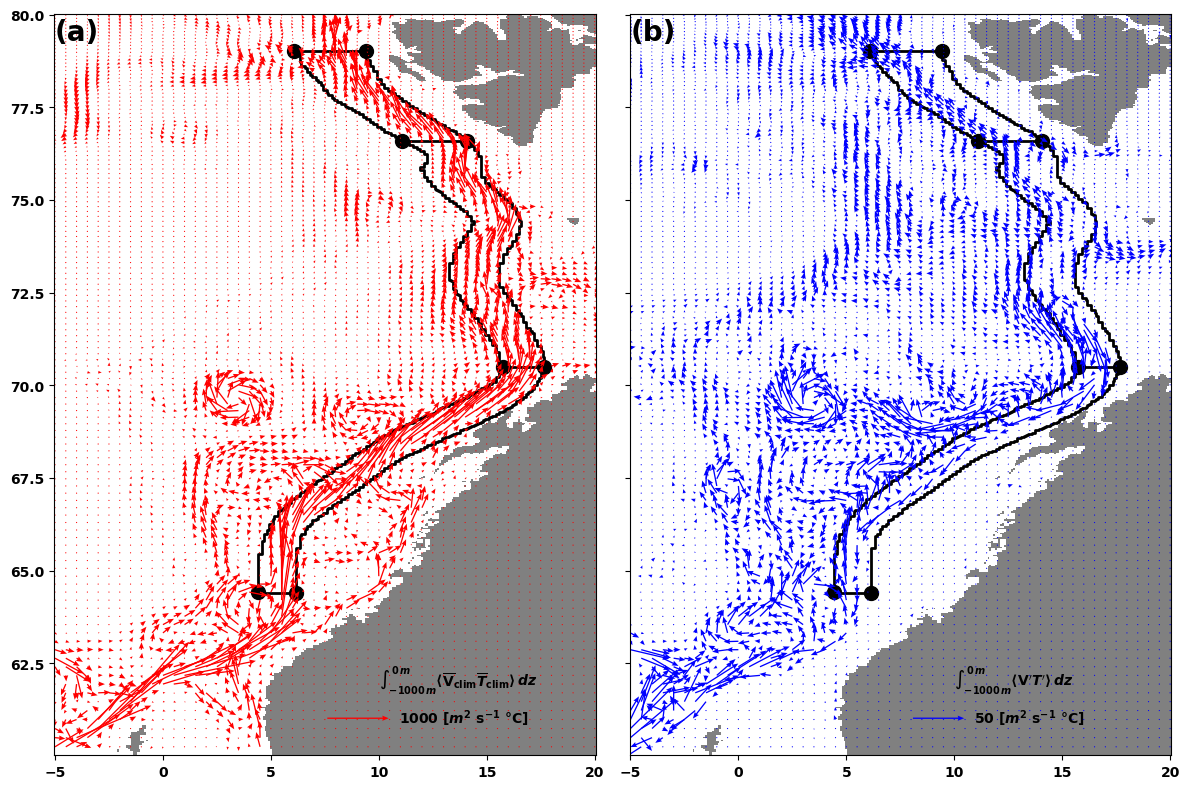

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), layout='constrained', sharey=True, sharex=True)

X,Y=np.meshgrid(mean_heat_flux_u_vec.XC[::x_spacing].sel(XC=XC_extend).data, \
                mean_heat_flux_u_vec.YC[::y_spacing].sel(YC=YC_extend).data)
u,v= (mean_heat_flux_u_vec* ds.drF[:43]).sum(axis=0)[::x_spacing,::y_spacing].sel(XC=XC_extend,YC=YC_extend), \
    (mean_heat_flux_v_vec* ds.drF[:43]).sum(axis=0)[::x_spacing,::y_spacing].sel(XC=XC_extend,YC=YC_extend)

u1,v1= (eddy_heat_flux_u_vec* ds.drF[:43]).sum(axis=0)[::x_spacing,::y_spacing].sel(XC=XC_extend,YC=YC_extend), \
    (eddy_heat_flux_v_vec* ds.drF[:43]).sum(axis=0)[::x_spacing,::y_spacing].sel(XC=XC_extend,YC=YC_extend)

linewidth=2
def plot_faces(ax, south_face, west_face, east_face, north_face):
    """Plot boundary faces on the given axis."""
    # Plot each face (South, West, East, North) with appropriate colors and labels
    ax.plot(south_face[:, 0], south_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label="South")
    ax.plot(west_face[:, 0], west_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='West')
    ax.plot(east_face[:, 0], east_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='East')
    ax.plot(north_face[:, 0], north_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='North')
    ax.plot(4.4166665,64.42213, 'o', markersize=10,color='k',)
    ax.plot(15.75,70.4921, 'o', markersize=10,color='k',)
    ax.plot(11.083333,76.58879, 'o', markersize=10,color='k',)
    ax.plot(6.0833335, 79.01265,'o', markersize=10,color='k',)
    ax.plot(south_face[-1, 0],south_face[0, 1], 'o', markersize=10,color='k',)
    ax.plot(north_face[-1, 0],north_face[0, 1], 'o', markersize=10,color='k',)
    ax.plot(14.083333, 76.58879, 'o', markersize=10,color='k',)
    ax.plot(17.666666, 70.4921,'o', markersize=10,color='k',)
def plot_diagonal_lines(ax, west_face, east_face, indices):
    """Plot diagonal lines connecting the west and east faces."""
    for idx_w, idx_e in indices:
        ax.plot([west_face[idx_w][0], east_face[idx_e][0]],
                [west_face[idx_w][1], east_face[idx_e][1]],
                linestyle='-', linewidth=linewidth, color='k')
for axes in ax:
    ds.maskInC.where(ds.maskInC==0).sel(XC=XC_extend, YC=YC_extend).plot(ax=axes, cmap='gray',add_colorbar=False,)
    axes.set_title("")
    axes.set_ylabel("")
    axes.set_xlabel("")
    plot_faces(axes, south_face, west_face, east_face, north_face)
    plot_diagonal_lines(axes, west_face, east_face, indices_for_lines)

Q1=ax[0].quiver(X,Y,u,v,  color='r', scale=None,zorder=2, headwidth =4)
Q2=ax[1].quiver(X,Y,u1,v1,  color='b', scale=None,zorder=2, headwidth =4)

text1 = (r"$\int_{-1000\,m}^{0\,m}\langle\overline{\boldsymbol{\mathbf{V}}}_{\mathrm{clim}} \overline{T}_{\mathrm{clim}}\rangle \,dz$")

ax[0].text(10, 62.5, text1, fontsize=10, va='top',ma='left',  )
text2 = (r"$\int_{-1000\,m}^{0\,m} \langle \mathbf{V}'T'  \rangle \,dz$")
ax[1].text(10, 62.5, text2, fontsize=10, va='top',ma='left',  )


ax[0].quiverkey(Q1, X=0.618, Y=0.05, U=1000, label=  r"1000 [$m^{2}$ s$^{-1}$ °C]", labelpos='E')
ax[1].quiverkey(Q2, X=0.618, Y=0.05, U=50, label=r"50 [$m^{2}$ s$^{-1}$ °C]", labelpos='E')
ax[0].text(-5, 79.9, "(a)", fontsize=20, va='top',ma='left', weight="bold", )
ax[1].text(-5, 79.9, "(b)", fontsize=20, va='top',ma='left', weight="bold", )

# ax[1].plot([11.083333, 14.083333], [76.58879,76.58879],  color='r', linestyle='-', linewidth=3,)
# ax[1].plot([15.75,17.666666], [70.4921,70.4921],  color='r', linestyle='-', linewidth=3,)
plt.tight_layout()
plt.show()
fig.savefig('../Manuscript/FIGs/FIG5_v2.png', bbox_inches='tight', transparent=True,dpi=500)


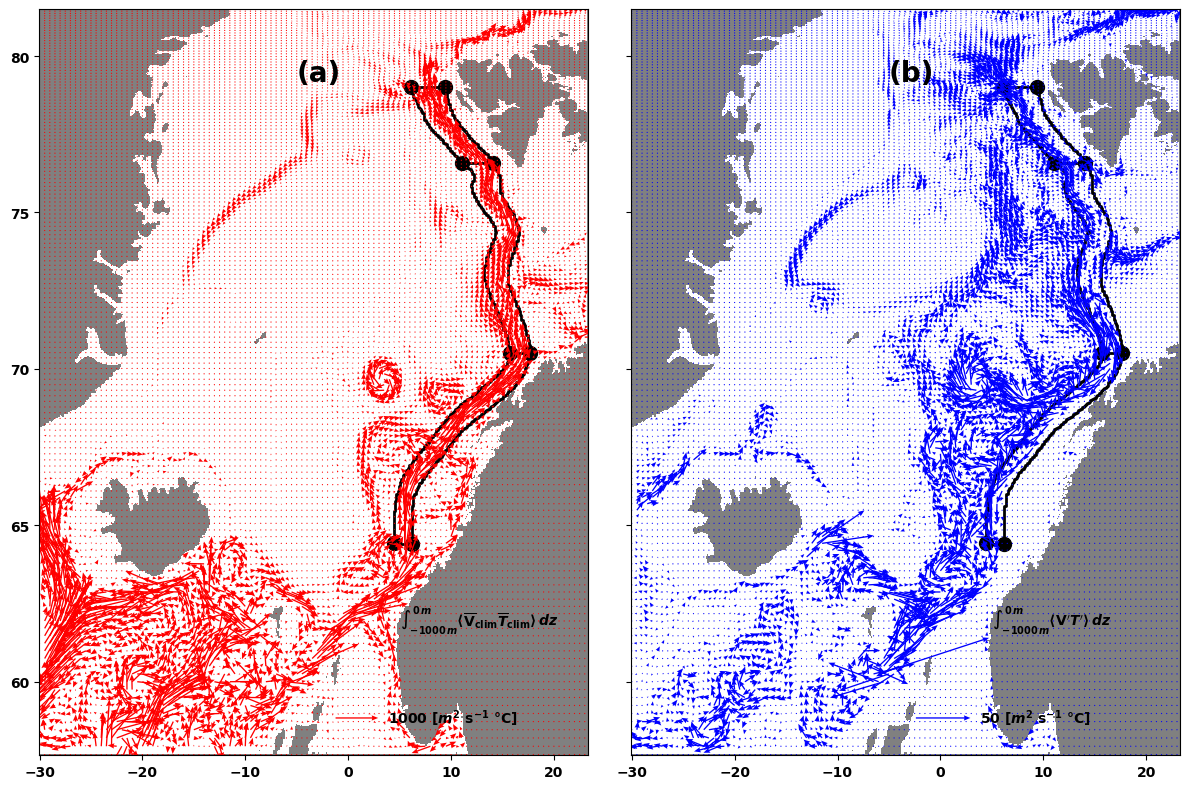

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), layout='constrained', sharey=True, sharex=True)

X,Y=np.meshgrid(mean_heat_flux_u_vec.XC[::x_spacing].data, \
                mean_heat_flux_u_vec.YC[::y_spacing].data)
u,v= (mean_heat_flux_u_vec* ds.drF[:43]).sum(axis=0)[::x_spacing,::y_spacing], \
    (mean_heat_flux_v_vec* ds.drF[:43]).sum(axis=0)[::x_spacing,::y_spacing]

u1,v1= (eddy_heat_flux_u_vec* ds.drF[:43]).sum(axis=0)[::x_spacing,::y_spacing], \
    (eddy_heat_flux_v_vec* ds.drF[:43]).sum(axis=0)[::x_spacing,::y_spacing]

linewidth=2
def plot_faces(ax, south_face, west_face, east_face, north_face):
    """Plot boundary faces on the given axis."""
    # Plot each face (South, West, East, North) with appropriate colors and labels
    ax.plot(south_face[:, 0], south_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label="South")
    ax.plot(west_face[:, 0], west_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='West')
    ax.plot(east_face[:, 0], east_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='East')
    ax.plot(north_face[:, 0], north_face[:, 1], color='k', linestyle='-', linewidth=linewidth, label='North')
    ax.plot(4.4166665,64.42213, 'o', markersize=10,color='k',)
    ax.plot(15.75,70.4921, 'o', markersize=10,color='k',)
    ax.plot(11.083333,76.58879, 'o', markersize=10,color='k',)
    ax.plot(6.0833335, 79.01265,'o', markersize=10,color='k',)
    ax.plot(south_face[-1, 0],south_face[0, 1], 'o', markersize=10,color='k',)
    ax.plot(north_face[-1, 0],north_face[0, 1], 'o', markersize=10,color='k',)
    ax.plot(14.083333, 76.58879, 'o', markersize=10,color='k',)
    ax.plot(17.666666, 70.4921,'o', markersize=10,color='k',)
def plot_diagonal_lines(ax, west_face, east_face, indices):
    """Plot diagonal lines connecting the west and east faces."""
    for idx_w, idx_e in indices:
        ax.plot([west_face[idx_w][0], east_face[idx_e][0]],
                [west_face[idx_w][1], east_face[idx_e][1]],
                linestyle='-', linewidth=linewidth, color='k')
for axes in ax:
    ds.maskInC.where(ds.maskInC==0).plot(ax=axes, cmap='gray',add_colorbar=False,)
    axes.set_title("")
    axes.set_ylabel("")
    axes.set_xlabel("")
    plot_faces(axes, south_face, west_face, east_face, north_face)
    plot_diagonal_lines(axes, west_face, east_face, indices_for_lines)

Q1=ax[0].quiver(X,Y,u,v,  color='r', scale=None,zorder=2, headwidth =4)
Q2=ax[1].quiver(X,Y,u1,v1,  color='b', scale=None,zorder=2, headwidth =4)

text1 = (r"$\int_{-1000\,m}^{0\,m}\langle\overline{\boldsymbol{\mathbf{V}}}_{\mathrm{clim}} \overline{T}_{\mathrm{clim}}\rangle \,dz$")

ax[0].text(5, 62.5, text1, fontsize=10, va='top',ma='left',  )
text2 = (r"$\int_{-1000\,m}^{0\,m} \langle \mathbf{V}'T'  \rangle \,dz$")
ax[1].text(5, 62.5, text2, fontsize=10, va='top',ma='left',  )


ax[0].quiverkey(Q1, X=0.618, Y=0.05, U=1000, label=  r"1000 [$m^{2}$ s$^{-1}$ °C]", labelpos='E')
ax[1].quiverkey(Q2, X=0.618, Y=0.05, U=50, label=r"50 [$m^{2}$ s$^{-1}$ °C]", labelpos='E')
ax[0].text(-5, 79.9, "(a)", fontsize=20, va='top',ma='left', weight="bold", )
ax[1].text(-5, 79.9, "(b)", fontsize=20, va='top',ma='left', weight="bold", )

# ax[1].plot([11.083333, 14.083333], [76.58879,76.58879],  color='r', linestyle='-', linewidth=3,)
# ax[1].plot([15.75,17.666666], [70.4921,70.4921],  color='r', linestyle='-', linewidth=3,)
plt.tight_layout()
plt.show()
#fig.savefig('../Manuscript/FIGs/FIG5_v2.png', bbox_inches='tight', transparent=True,dpi=500)


In [62]:
(eddy_heat_flux_u_vec* ds.drF[:43]).sum(axis=0)

<xarray.DataArray (YC: 936, XC: 640)>
dask.array<sum-aggregate, shape=(936, 640), dtype=float32, chunksize=(936, 640), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 57.67 57.71 57.76 57.8 ... 81.46 81.47 81.49 81.5
  * XC       (XC) float32 -30.0 -29.92 -29.83 -29.75 ... 23.0 23.08 23.17 23.25
    rA       (YC, XC) float32 2.456e+07 2.456e+07 ... 1.882e+06 1.883e+06
    Depth    (YC, XC) float32 2.31e+03 2.374e+03 2.384e+03 ... 637.5 644.2 644.2
    maskInC  (YC, XC) bool False False False False ... False False False False
    dyF      (YC, XC) float32 4.956e+03 4.956e+03 ... 1.374e+03 1.374e+03
    dxF      (YC, XC) float32 4.956e+03 4.956e+03 ... 1.37e+03 1.37e+03

# FIG6

In [63]:
cp = 3986  # J/(kg·K)
rho0=1027  # kg/m3

mooring_west_combined_west_shifted =xr.concat([
                    ds.isel(
                    XC=xr.DataArray(west_index_x, dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(west_index_y, dims='mooring'),),
                ds.isel(
                    XC=xr.DataArray(west_index_x-1, dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(west_index_y, dims='mooring'),)], dim='paths')
#mooring_west_combined_west_shifted = mooring_south_combined.assign_coords(paths=['original', 'west_shifted'])

mooring_west_combined_north_shifted =xr.concat([
                    ds.isel(
                    XC=xr.DataArray(west_index_x, dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(west_index_y, dims='mooring'),),
                ds.isel(
                    XC=xr.DataArray(west_index_x, dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(west_index_y+1, dims='mooring'),)], dim='paths')


## remove a few mooring
mooring_east_combined_east_shifted =xr.concat([
                    ds.isel(XC=xr.DataArray(east_index_x[:852], dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(east_index_y[:852], dims='mooring'),),
                ds.isel(XC=xr.DataArray(east_index_x[:852]+1, dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(east_index_y[:852], dims='mooring'),)], dim='paths')
mooring_east_combined_north_shifted =xr.concat([
                    ds.isel(XC=xr.DataArray(east_index_x[:852], dims='mooring'), 
                        YC=xr.DataArray(east_index_y[:852], dims='mooring'),),
                ds.isel(XC=xr.DataArray(east_index_x[:852], dims='mooring'), ##remove 1 corner to facilitate calculation
                    YC=xr.DataArray(east_index_y[:852]+1, dims='mooring'),)], dim='paths')

##  raw data: theta, U, V  :
def extract_west_boundary():

    THETA_for_u = mooring_west_combined_west_shifted.THETA.mean('paths')#* west_mooring_U_dir
    THETA_for_v = mooring_west_combined_north_shifted.THETA.mean('paths') #* west_mooring_V_dir
    Vtransport = west_mooring_way2.VVELMASS * west_mooring_way2.dxG * west_mooring_way2.drF# * mooring.hFacS
    Utransport = west_mooring_way2.UVELMASS * west_mooring_way2.dyG * west_mooring_way2.drF# * mooring.hFacW
    V_dir= west_mooring_V_dir
    U_dir= west_mooring_U_dir
    
    
    THETA_for_u=THETA_for_u.sel(time=~((THETA_for_u.time == np.datetime64("2000-01-02")) | (THETA_for_u.time == np.datetime64("2006-01-05"))| (THETA_for_u.time == np.datetime64("2012-01-04"))))
    THETA_for_v=THETA_for_v.sel(time=~((THETA_for_v.time == np.datetime64("2000-01-02")) | (THETA_for_v.time == np.datetime64("2006-01-05"))|(THETA_for_v.time == np.datetime64("2012-01-04"))))
    Vtransport=Vtransport.sel(time=~((Vtransport.time == np.datetime64("2000-01-02")) | (Vtransport.time == np.datetime64("2006-01-05"))|(Vtransport.time == np.datetime64("2012-01-04"))))
    Utransport=Utransport.sel(time=~((Utransport.time == np.datetime64("2000-01-02")) | (Utransport.time == np.datetime64("2006-01-05"))|(Utransport.time == np.datetime64("2012-01-04"))))
    
    
    # Step 1: Calculate the seasonal climatologies
    U_clim = Utransport.groupby("time.season").mean("time")
    V_clim = Vtransport.groupby("time.season").mean("time")
    THETA_u_clim = THETA_for_u.groupby("time.season").mean("time")
    THETA_v_clim = THETA_for_v.groupby("time.season").mean("time")
    
    # Step 2: Calculate anomalies relavtive to  seasonal climatologies
    U_anom = Utransport.groupby("time.season") - U_clim
    V_anom = Vtransport.groupby("time.season") - V_clim
    THETA_u_anom = THETA_for_u.groupby("time.season") - THETA_u_clim
    THETA_v_anom = THETA_for_v.groupby("time.season") - THETA_v_clim
    
    
    
    TRANSPORT = (Vtransport * V_dir   + Utransport * U_dir ) *1e-6
    TRANSPORT_clim = (V_clim * V_dir   + U_clim * U_dir ) *1e-6
    TRANSPORT_anom = (V_anom * V_dir   + U_anom * U_dir ) *1e-6
    
    # Calculate derived variables
    HEATFLUX_tot = (Vtransport * V_dir * THETA_for_v  + Utransport * U_dir * THETA_for_u)* cp *rho0 * 1e-12  #.sum(['Z','mooring']) * cp *rho0 * 1e-12
        ## cal mean    
    HEATFLUX_mean = (Vtransport.mean('time')* V_dir  * THETA_for_v.mean('time')  +\
                     Utransport.mean('time')* U_dir  * THETA_for_u.mean('time'))  * cp *rho0 * 1e-12
    HEATFLUX_SEASON_mean = (V_clim * V_dir  * THETA_v_clim + U_clim * U_dir  * THETA_u_clim ) * cp *rho0 * 1e-12
    
    HEATFLUX_anom = HEATFLUX_tot.groupby('time.season')- HEATFLUX_SEASON_mean

    ## cal eddy
    HEATFLUX_eddy = (V_anom * V_dir* THETA_v_anom  +  U_anom * U_dir* THETA_u_anom) * cp *rho0 * 1e-12
    
    HEATFLUX_theta_driven =  (THETA_v_anom.groupby('time.season') * V_clim  * V_dir + THETA_u_anom.groupby('time.season') * U_clim  * U_dir) * cp *rho0 * 1e-12
    HEATFLUX_volume_driven =  (V_anom.groupby('time.season') * THETA_v_clim * V_dir + U_anom.groupby('time.season')  * THETA_u_clim  * U_dir) * cp *rho0 * 1e-12


    # Step 3: Create a new Dataset with simplified names
    ds_new = xr.Dataset({
        "U": Utransport,
        "U_clim": U_clim,
        "U_anom": U_anom,
        
        "V": Vtransport,
        "V_clim": V_clim,
        "V_anom": V_anom,
    
        "TRANSPORT":TRANSPORT,
        "TRANSPORT_clim":TRANSPORT_clim,
        "TRANSPORT_anom":TRANSPORT_anom,
        
        "THETA_u": THETA_for_u,
        "THETA_u_clim": THETA_u_clim,
        "THETA_u_anom": THETA_u_anom,
        
        "THETA_v": THETA_for_v,
        "THETA_v_clim": THETA_v_clim,
        "THETA_v_anom": THETA_v_anom,
    
    
        "HEATFLUX_tot": HEATFLUX_tot,
        "HEATFLUX_mean": HEATFLUX_mean,
        "HEATFLUX_SEASON_mean": HEATFLUX_SEASON_mean,
       
        "HEATFLUX_anom":HEATFLUX_anom,
        "HEATFLUX_eddy": HEATFLUX_eddy,  
        "HEATFLUX_theta_driven": HEATFLUX_theta_driven,
        "HEATFLUX_volume_driven": HEATFLUX_volume_driven,
    })
    
    # Display the new dataset structure
    return ds_new


##  raw data: theta, U, V  :
def extract_west_boundary_using_snap():
    THETA_for_u = mooring_west_combined_west_shifted.T.mean('paths')#* west_mooring_U_dir
    THETA_for_v = mooring_west_combined_north_shifted.T.mean('paths') #* west_mooring_V_dir
    Vtransport = west_mooring_way2.V * west_mooring_way2.dxG * west_mooring_way2.drF# * mooring.hFacS
    Utransport = west_mooring_way2.U * west_mooring_way2.dyG * west_mooring_way2.drF# * mooring.hFacW
    V_dir= west_mooring_V_dir
    U_dir= west_mooring_U_dir
    
    
    THETA_for_u=THETA_for_u.sel(time=~((THETA_for_u.time == np.datetime64("2000-01-02")) | (THETA_for_u.time == np.datetime64("2006-01-05"))| (THETA_for_u.time == np.datetime64("2012-01-04"))))
    THETA_for_v=THETA_for_v.sel(time=~((THETA_for_v.time == np.datetime64("2000-01-02")) | (THETA_for_v.time == np.datetime64("2006-01-05"))|(THETA_for_v.time == np.datetime64("2012-01-04"))))
    Vtransport=Vtransport.sel(time=~((Vtransport.time == np.datetime64("2000-01-02")) | (Vtransport.time == np.datetime64("2006-01-05"))|(Vtransport.time == np.datetime64("2012-01-04"))))
    Utransport=Utransport.sel(time=~((Utransport.time == np.datetime64("2000-01-02")) | (Utransport.time == np.datetime64("2006-01-05"))|(Utransport.time == np.datetime64("2012-01-04"))))
    
    
    # Step 1: Calculate the seasonal climatologies
    U_clim = Utransport.groupby("time.season").mean("time")
    V_clim = Vtransport.groupby("time.season").mean("time")
    THETA_u_clim = THETA_for_u.groupby("time.season").mean("time")
    THETA_v_clim = THETA_for_v.groupby("time.season").mean("time")
    
    # Step 2: Calculate anomalies relavtive to  seasonal climatologies
    U_anom = Utransport.groupby("time.season") - U_clim
    V_anom = Vtransport.groupby("time.season") - V_clim
    THETA_u_anom = THETA_for_u.groupby("time.season") - THETA_u_clim
    THETA_v_anom = THETA_for_v.groupby("time.season") - THETA_v_clim
    
    TRANSPORT = (Vtransport * V_dir   + Utransport * U_dir ) *1e-6
    TRANSPORT_clim = (V_clim * V_dir   + U_clim * U_dir ) *1e-6
    TRANSPORT_anom = (V_anom * V_dir   + U_anom * U_dir ) *1e-6
    
    # Calculate derived variables
    HEATFLUX_tot = (Vtransport * V_dir * THETA_for_v  + Utransport * U_dir * THETA_for_u)* cp *rho0 * 1e-12  #.sum(['Z','mooring']) * cp *rho0 * 1e-12
        ## cal mean    
    HEATFLUX_mean = (Vtransport.mean('time')* V_dir  * THETA_for_v.mean('time')  +\
                     Utransport.mean('time')* U_dir  * THETA_for_u.mean('time'))  * cp *rho0 * 1e-12
    HEATFLUX_SEASON_mean = (V_clim * V_dir  * THETA_v_clim + U_clim * U_dir  * THETA_u_clim ) * cp *rho0 * 1e-12
    
    HEATFLUX_anom = HEATFLUX_tot.groupby('time.season')- HEATFLUX_SEASON_mean

    ## cal eddy
    HEATFLUX_eddy = (V_anom * V_dir* THETA_v_anom  +  U_anom * U_dir* THETA_u_anom) * cp *rho0 * 1e-12
    
    HEATFLUX_theta_driven =  (THETA_v_anom.groupby('time.season') * V_clim  * V_dir + THETA_u_anom.groupby('time.season') * U_clim  * U_dir) * cp *rho0 * 1e-12
    HEATFLUX_volume_driven =  (V_anom.groupby('time.season') * THETA_v_clim * V_dir + U_anom.groupby('time.season')  * THETA_u_clim  * U_dir) * cp *rho0 * 1e-12



    
    # Step 3: Create a new Dataset with simplified names
    ds_new = xr.Dataset({
        "U": Utransport,
        "U_clim": U_clim,
        "U_anom": U_anom,
        
        "V": Vtransport,
        "V_clim": V_clim,
        "V_anom": V_anom,
    
        "TRANSPORT":TRANSPORT,
        "TRANSPORT_clim":TRANSPORT_clim,
        "TRANSPORT_anom":TRANSPORT_anom,
        
        "THETA_u": THETA_for_u,
        "THETA_u_clim": THETA_u_clim,
        "THETA_u_anom": THETA_u_anom,
        
        "THETA_v": THETA_for_v,
        "THETA_v_clim": THETA_v_clim,
        "THETA_v_anom": THETA_v_anom,
    
    
        "HEATFLUX_tot": HEATFLUX_tot,
        "HEATFLUX_mean": HEATFLUX_mean,
        "HEATFLUX_SEASON_mean": HEATFLUX_SEASON_mean,
       
        "HEATFLUX_anom":HEATFLUX_anom,
        "HEATFLUX_eddy": HEATFLUX_eddy,  
        "HEATFLUX_theta_driven": HEATFLUX_theta_driven,
        "HEATFLUX_volume_driven": HEATFLUX_volume_driven,
    })
    
    # Display the new dataset structure
    return ds_new

WEST_BOUNDARY_using_snap = extract_west_boundary_using_snap()

WEST_BOUNDARY_using_avg =extract_west_boundary()
# add EKE
# (np.power(WEST_BOUNDARY_using_snap.U_anom, 2) + np.power(WEST_BOUNDARY_using_snap.V_anom, 2))/2

In [64]:
%%time
HEATFLUX_eddy_values = WEST_BOUNDARY_using_snap.HEATFLUX_eddy.groupby('time.season').mean('time').values
HEATFLUX_mean_values = WEST_BOUNDARY_using_snap.HEATFLUX_SEASON_mean.values

CPU times: user 12min 34s, sys: 20min 37s, total: 33min 11s
Wall time: 7min 20s


0 DJF blue
2 MAM green
1 JJA red
3 SON orange


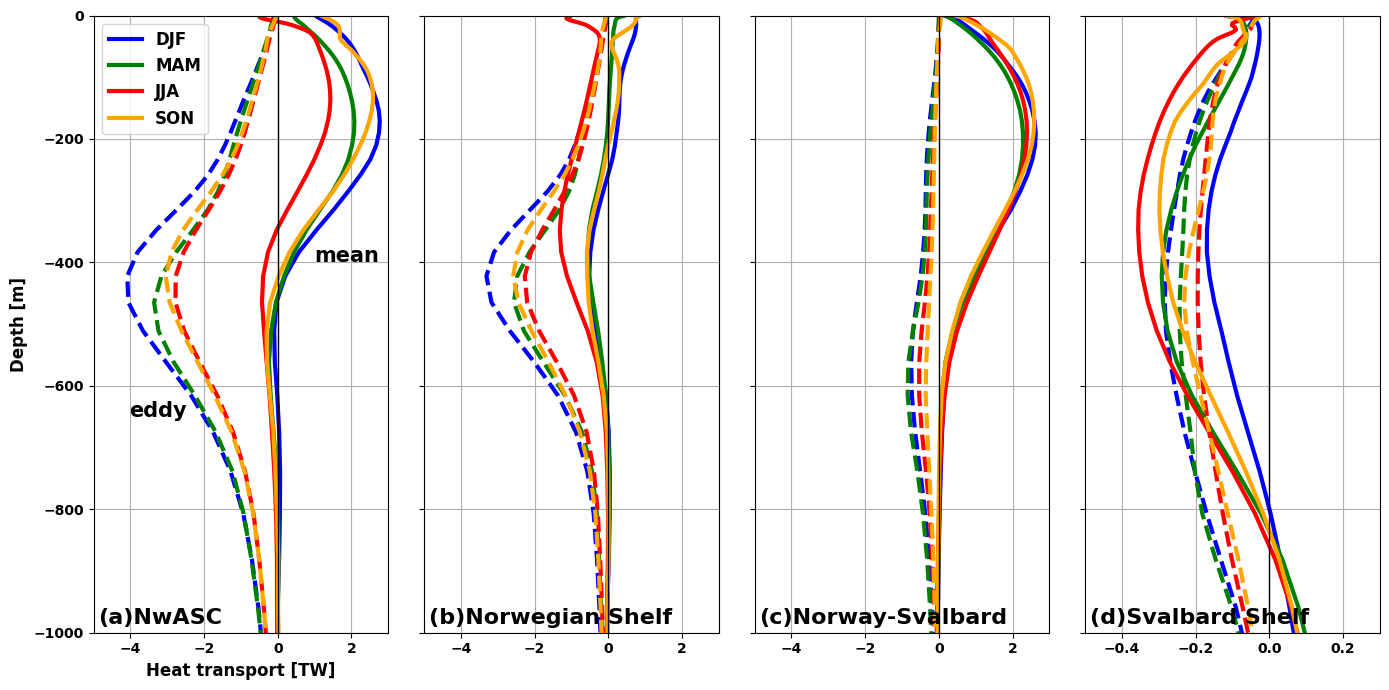

In [65]:
seasons = ['DJF', 'MAM','JJA', 'SON']
colors = ['blue', 'green', 'red', 'orange'] 

for i, season,color in zip([0,2,1,3],seasons,colors):
    print(i, season, color)


fig, axes = plt.subplots(1,4, figsize=(14, 7),sharey=True,sharex=False,)
Z = ds.Z[:44]#.sel(Z=slice(None, -3000))
# Plot HEATFLUX_eddy_values (dashed lines)
seasons = ['DJF', 'MAM','JJA', 'SON']
colors = ['blue', 'green', 'red', 'orange'] 
for i, season,color in zip([0,2,1,3],seasons,colors):

    axes.flatten()[0].plot(HEATFLUX_eddy_values[i, :44,:].sum(axis=1), Z,  lw=3, linestyle='--', color=color)
    axes.flatten()[0].plot(HEATFLUX_mean_values[i, :44,:].sum(axis=1), Z,label=season, lw=3, linestyle='-', color=color)
   
    axes.flatten()[1].plot(HEATFLUX_eddy_values[i, :44,:327].sum(axis=1), Z,  lw=3, linestyle='--', color=color)
    axes.flatten()[1].plot(HEATFLUX_mean_values[i, :44,:327].sum(axis=1), Z,label=season, lw=3, linestyle='-', color=color)

    axes.flatten()[2].plot(HEATFLUX_eddy_values[i, :44,327:680].sum(axis=1), Z,  lw=3, linestyle='--', color=color)
    axes.flatten()[2].plot(HEATFLUX_mean_values[i, :44,327:680].sum(axis=1), Z,label=season, lw=3, linestyle='-', color=color)

    axes.flatten()[3].plot(HEATFLUX_eddy_values[i, :44,680:].sum(axis=1), Z,  lw=3, linestyle='--', color=color)
    axes.flatten()[3].plot(HEATFLUX_mean_values[i, :44,680:].sum(axis=1), Z,label=season, lw=3, linestyle='-', color=color)
    

labels= ["(a)NwASC", "(b)Norwegian Shelf","(c)Norway-Svalbard","(d)Svalbard Shelf",]
for ax, label in zip(axes.flatten(), labels):
    ax.grid()
    
    ax.text(0.0155, 0.04, label, fontsize=16, va='top', ha='left', weight="bold", transform=ax.transAxes)
# Add a legend to the plot
    #ax.legend(title='Season', loc='upper right')
    ax.grid(which="major", linestyle="-")
    ax.grid(which="minor", linestyle="--")
    ax.set_ylim(-1000,0)
    ax.axvline(x=0, color='black', linewidth=1, linestyle='-', )



axes[0].set_xlim(-5,3)
axes[1].set_xlim(-5,3)
axes[2].set_xlim(-5,3)
axes[3].set_xlim(-0.5,0.3)

axes[0].legend(fontsize=12,loc='upper left')
axes[0].set_xlabel("Heat transport [TW]",fontsize=12,)
axes[0].set_ylabel("Depth [m]",fontsize=12,)

axes[0].text(0.12, 0.35, "eddy", fontsize=15,  weight="bold", transform=axes[0].transAxes )
axes[0].text(0.75, 0.6, "mean", fontsize=15,  weight="bold", transform=axes[0].transAxes )

plt.tight_layout()
plt.show()

fig.savefig('../Manuscript/FIGs/FIG6.png', bbox_inches='tight', transparent=True,dpi=500)


In [66]:
%%time
HEATFLUX_eddy_values_avg = WEST_BOUNDARY_using_avg.HEATFLUX_eddy.groupby('time.season').mean('time').values
HEATFLUX_mean_values_avg = WEST_BOUNDARY_using_avg.HEATFLUX_SEASON_mean.values

CPU times: user 12min 30s, sys: 20min 32s, total: 33min 3s
Wall time: 5min 27s


0 DJF blue
2 MAM green
1 JJA red
3 SON orange


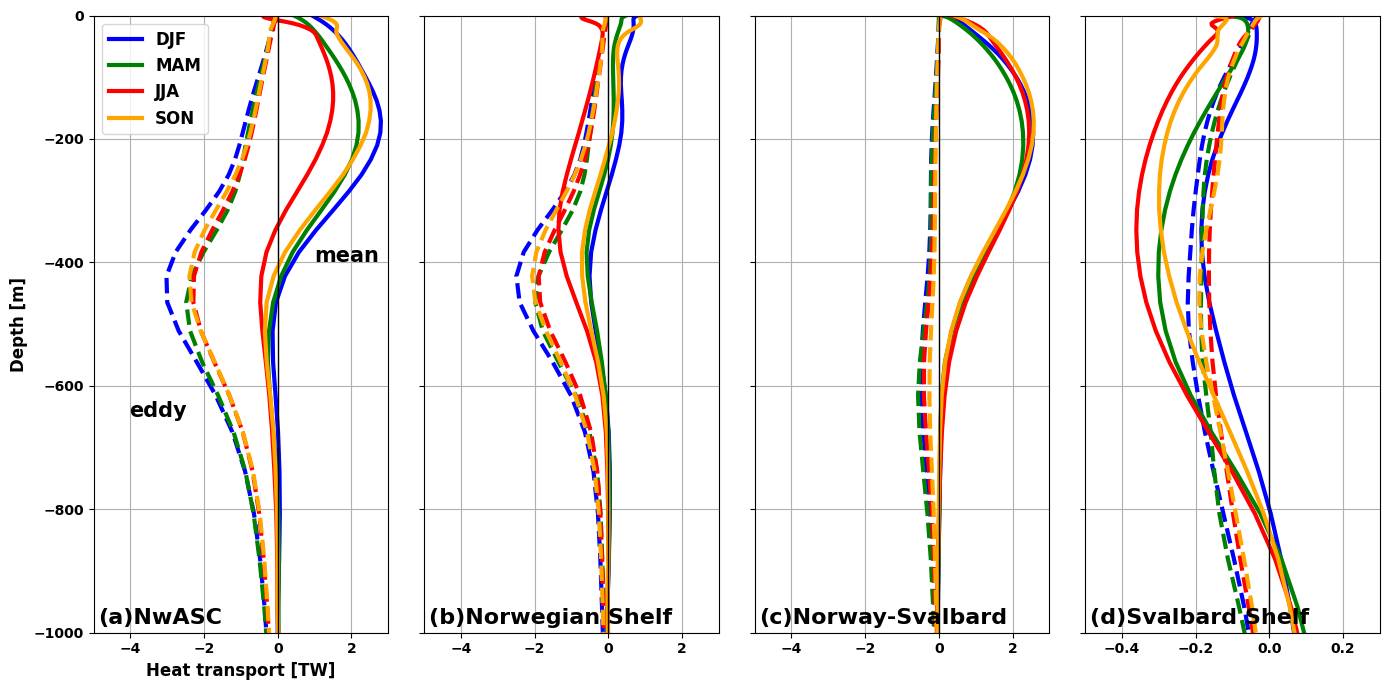

In [67]:
seasons = ['DJF', 'MAM','JJA', 'SON']
colors = ['blue', 'green', 'red', 'orange'] 

for i, season,color in zip([0,2,1,3],seasons,colors):
    print(i, season, color)


fig, axes = plt.subplots(1,4, figsize=(14, 7),sharey=True,sharex=False,)
Z = ds.Z[:44]#.sel(Z=slice(None, -3000))
# Plot HEATFLUX_eddy_values (dashed lines)
seasons = ['DJF', 'MAM','JJA', 'SON']
colors = ['blue', 'green', 'red', 'orange'] 
for i, season,color in zip([0,2,1,3],seasons,colors):

    axes.flatten()[0].plot(HEATFLUX_eddy_values_avg[i, :44,:].sum(axis=1), Z,  lw=3, linestyle='--', color=color)
    axes.flatten()[0].plot(HEATFLUX_mean_values_avg[i, :44,:].sum(axis=1), Z,label=season, lw=3, linestyle='-', color=color)
   
    axes.flatten()[1].plot(HEATFLUX_eddy_values_avg[i, :44,:327].sum(axis=1), Z,  lw=3, linestyle='--', color=color)
    axes.flatten()[1].plot(HEATFLUX_mean_values_avg[i, :44,:327].sum(axis=1), Z,label=season, lw=3, linestyle='-', color=color)

    axes.flatten()[2].plot(HEATFLUX_eddy_values_avg[i, :44,327:680].sum(axis=1), Z,  lw=3, linestyle='--', color=color)
    axes.flatten()[2].plot(HEATFLUX_mean_values_avg[i, :44,327:680].sum(axis=1), Z,label=season, lw=3, linestyle='-', color=color)

    axes.flatten()[3].plot(HEATFLUX_eddy_values_avg[i, :44,680:].sum(axis=1), Z,  lw=3, linestyle='--', color=color)
    axes.flatten()[3].plot(HEATFLUX_mean_values_avg[i, :44,680:].sum(axis=1), Z,label=season, lw=3, linestyle='-', color=color)
    

labels= ["(a)NwASC", "(b)Norwegian Shelf","(c)Norway-Svalbard","(d)Svalbard Shelf",]
for ax, label in zip(axes.flatten(), labels):
    ax.grid()
    
    ax.text(0.0155, 0.04, label, fontsize=16, va='top', ha='left', weight="bold", transform=ax.transAxes)
# Add a legend to the plot
    #ax.legend(title='Season', loc='upper right')
    ax.grid(which="major", linestyle="-")
    ax.grid(which="minor", linestyle="--")
    ax.set_ylim(-1000,0)
    ax.axvline(x=0, color='black', linewidth=1, linestyle='-', )



axes[0].set_xlim(-5,3)
axes[1].set_xlim(-5,3)
axes[2].set_xlim(-5,3)
axes[3].set_xlim(-0.5,0.3)

axes[0].legend(fontsize=12,loc='upper left')
axes[0].set_xlabel("Heat transport [TW]",fontsize=12,)
axes[0].set_ylabel("Depth [m]",fontsize=12,)

axes[0].text(0.12, 0.35, "eddy", fontsize=15,  weight="bold", transform=axes[0].transAxes )
axes[0].text(0.75, 0.6, "mean", fontsize=15,  weight="bold", transform=axes[0].transAxes )

plt.tight_layout()
plt.show()

fig.savefig('../Manuscript/FIGs/FIG6_avg.png', bbox_inches='tight', transparent=True,dpi=500)


# FIG7

In [68]:
sTHETA = ds.T*(1+ds.Eta/ds.Depth).where(ds.hFacC)
sTHETA_cli= sTHETA.groupby("time.season").mean("time")
sTHETA_anom=sTHETA.groupby("time.season")-sTHETA_cli

sTHETA_mean = sTHETA.where(mask).sel(Z=slice(0,-1000),YC=slice(64.4,79)).mean(['time','XC']).compute()
sTHETA_var = (sTHETA_anom.where(mask).sel(Z=slice(0,-1000),YC=slice(64.4,79)).mean(['XC'])**2).mean('time').compute()



In [69]:
# U_clim = ds.U.groupby("time.season").mean("time")
# V_clim = ds.V.groupby("time.season").mean("time")
# U_anom= ds.U.groupby("time.season") - U_clim
# V_anom= ds.V.groupby("time.season") - V_clim

# U_anom = grid.interp(U_anom, "X", boundary="fill", fill_value=np.nan)
# V_anom = grid.interp(V_anom, "Y", boundary="fill", fill_value=np.nan)

# # Sum squared values
# sum2 = np.power(U_anom, 2) + np.power(V_anom, 2)
# eke = sum2/2
# NwASC_eke = eke.where(ds.maskC).where(mask).sel(Z=slice(0,-1000),YC=slice(64.4,79)).mean(['time','XC']).compute()


In [70]:
U_clim = ds.UVELMASS.groupby("time.season").mean("time")
V_clim = ds.VVELMASS.groupby("time.season").mean("time")
U_anom= ds.UVELMASS.groupby("time.season") - U_clim
V_anom= ds.VVELMASS.groupby("time.season") - V_clim

U_anom = grid.interp(U_anom, "X", boundary="fill", fill_value=np.nan)
V_anom = grid.interp(V_anom, "Y", boundary="fill", fill_value=np.nan)

# Sum squared values
sum2 = np.power(U_anom, 2) + np.power(V_anom, 2)
eke2 = sum2/2
NwASC_eke2 = eke2.where(ds.maskC).where(mask).sel(Z=slice(0,-1000),YC=slice(64.4,79)).mean(['time','XC']).compute()


In [71]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 7) ,sharex=True,sharey=True)
# p1=sTHETA_mean.plot.contourf(ax=axes.flatten()[0], robust=True, x='YC', cmap=plt.cm.RdBu_r, levels=np.arange(0, 9, 0.5), cbar_kwargs={'extend': 'both', 'shrink': 1,'pad':0.03, 'label': "$^\circ$C"}, )
# p2=sTHETA_var.plot.contourf(ax=axes.flatten()[1], robust=True, x='YC', cmap=plt.cm.RdBu_r,levels=np.arange(0, 2.1, 0.1), cbar_kwargs={'extend': 'both', 'shrink': 1,'pad':0.03, 'label': r"$({}^\circ\mathrm{C})^2$"})
# p3=NwASC_eke.plot.contourf(ax=axes.flatten()[2], robust=True,cmap=parula,levels=np.linspace(0,0.05,11), 
#         cbar_kwargs={'extend': 'both', 'shrink': 1, 'pad':0.03,'label': "[$m^{2} s^{-2}$]"})
# # (volume_var*1e-6).plot.contourf(ax=axes.flatten()[3], robust=True,cmap=parula,levels=np.arange(0,13,1),
# #                                 cbar_kwargs={'extend': 'both', 'shrink': 0.618, 'pad':0.03,'label': "[$m^{2} s^{-1}Sv$]"})

# labels= [r"(a)$\langle {T}\rangle$ ",r"(b)$\langle T'^{2} \rangle $",r"(c)$EKE$"]


# for ax, label in zip(axes.flatten(), labels, ):
#     ax.set_xticks([])
#     ax.set_xlabel("")
#     ax.set_ylabel("")
#     ax.text(0, 0.98, label, fontsize=20, va='top', ha='left', weight="bold", 
#            transform=ax.transAxes)

# axes.flatten()[2].set_xticks(np.arange(66,80,2))
# axes.flatten()[2].set_xlabel("latitude [°N]")
# #axes.flatten()[3].set_xlabel("latitude")
# axes.flatten()[2].set_ylabel("depth[m]")
# plt.tight_layout()
# plt.show()

# fig.savefig('../Manuscript/FIGs/FIG7.png', bbox_inches='tight', transparent=True,dpi=500)



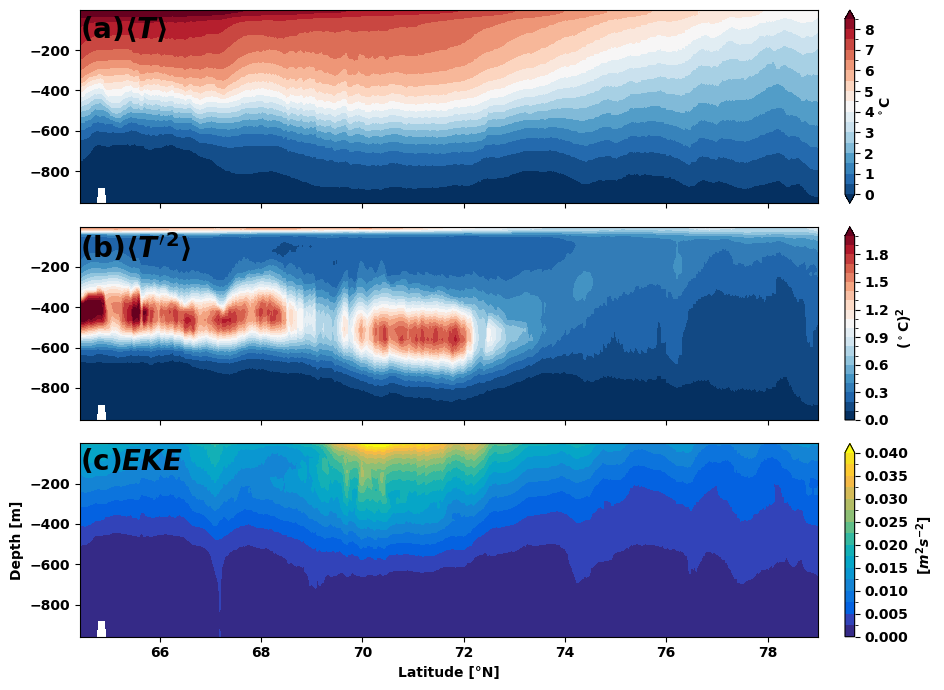

In [72]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7) ,sharex=True,sharey=True)
p1=sTHETA_mean.plot.contourf(ax=axes.flatten()[0], robust=True, x='YC', cmap=plt.cm.RdBu_r, levels=np.arange(0, 9, 0.5), cbar_kwargs={'extend': 'both', 'shrink': 1,'pad':0.03, 'label': "$^\circ$C"}, )
p2=sTHETA_var.plot.contourf(ax=axes.flatten()[1], robust=True, x='YC', cmap=plt.cm.RdBu_r,levels=np.arange(0, 2.1, 0.1), cbar_kwargs={'extend': 'both', 'shrink': 1,'pad':0.03, 'label': r"$({}^\circ\mathrm{C})^2$"})
p3=NwASC_eke2.plot.contourf(ax=axes.flatten()[2], robust=True,cmap=parula,levels=np.linspace(0,0.04,17), 
        cbar_kwargs={'extend': 'both', 'shrink': 1, 'pad':0.03,'label': "[$m^{2} s^{-2}$]"})
# (volume_var*1e-6).plot.contourf(ax=axes.flatten()[3], robust=True,cmap=parula,levels=np.arange(0,13,1),
#                                 cbar_kwargs={'extend': 'both', 'shrink': 0.618, 'pad':0.03,'label': "[$m^{2} s^{-1}Sv$]"})

labels= [r"(a)$\langle {T}\rangle$ ",r"(b)$\langle T'^{2} \rangle $",r"(c)$EKE$"]


for ax, label in zip(axes.flatten(), labels, ):
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(0, 0.98, label, fontsize=20, va='top', ha='left', weight="bold", 
           transform=ax.transAxes)

axes.flatten()[2].set_xticks(np.arange(66,80,2))
axes.flatten()[2].set_xlabel("Latitude [°N]")
#axes.flatten()[3].set_xlabel("latitude")
axes.flatten()[2].set_ylabel("Depth [m]")
plt.tight_layout()
plt.show()

fig.savefig('../Manuscript/FIGs/FIG7.png', bbox_inches='tight', transparent=True,dpi=500)



# FIG8

In [73]:
%%time
TOT=WEST_BOUNDARY_using_snap.HEATFLUX_tot.values
SEASON_mean=WEST_BOUNDARY_using_snap.HEATFLUX_SEASON_mean.values
EDDY=WEST_BOUNDARY_using_snap.HEATFLUX_eddy.values



CPU times: user 18min 20s, sys: 31min 2s, total: 49min 23s
Wall time: 8min 52s


In [74]:
%%time
ANOM = WEST_BOUNDARY_using_snap.HEATFLUX_anom.values
H_THETA = WEST_BOUNDARY_using_snap.HEATFLUX_theta_driven.values
H_VOLUME = WEST_BOUNDARY_using_snap.HEATFLUX_volume_driven.values



CPU times: user 19min 58s, sys: 31min 35s, total: 51min 33s
Wall time: 8min 52s


In [75]:
%%time
monthly_window_size = 6
three_monthly_window_size = 18
halfyearly_window_size = 36
yearly_window_size = 72
# Calculate the centered 30-day running mean using uniform filter
from scipy.ndimage import uniform_filter1d
depth_idx_start=0
depth_idx_end=72 #43
window_size=yearly_window_size

H_anom_s1_1Y_runningmean = uniform_filter1d(ANOM[:,:depth_idx_end,:327].sum(axis=(1,2)) , size=window_size, mode='reflect')
H_eddy_s1_1Y_runningmean = uniform_filter1d(EDDY[:,:depth_idx_end,:327].sum(axis=(1,2)), size=window_size, mode='reflect')
H_theta_s1_1Y_runningmean = uniform_filter1d(H_THETA[:,:depth_idx_end,:327].sum(axis=(1,2)), size=window_size, mode='reflect')
H_volume_s1_1Y_runningmean = uniform_filter1d(H_VOLUME[:,:depth_idx_end,:327].sum(axis=(1,2)), size=window_size, mode='reflect')

H_anom_s2_1Y_runningmean = uniform_filter1d(ANOM[:,:depth_idx_end,327:680].sum(axis=(1,2)), size=window_size, mode='reflect')
H_eddy_s2_1Y_runningmean = uniform_filter1d(EDDY[:,:depth_idx_end,327:680].sum(axis=(1,2)), size=window_size, mode='reflect')
H_theta_s2_1Y_runningmean = uniform_filter1d(H_THETA[:,:depth_idx_end,327:680].sum(axis=(1,2)), size=window_size, mode='reflect')
H_volume_s2_1Y_runningmean = uniform_filter1d(H_VOLUME[:,:depth_idx_end,327:680].sum(axis=(1,2)), size=window_size, mode='reflect')

H_anom_s3_1Y_runningmean = uniform_filter1d(ANOM[:,:depth_idx_end,680:].sum(axis=(1,2)), size=window_size, mode='reflect')
H_eddy_s3_1Y_runningmean = uniform_filter1d(EDDY[:,:depth_idx_end,680:].sum(axis=(1,2)), size=window_size, mode='reflect')
H_theta_s3_1Y_runningmean = uniform_filter1d(H_THETA[:,:depth_idx_end,680:].sum(axis=(1,2)), size=window_size, mode='reflect')
H_volume_s3_1Y_runningmean = uniform_filter1d(H_VOLUME[:,:depth_idx_end,680:].sum(axis=(1,2)), size=window_size, mode='reflect')


CPU times: user 618 ms, sys: 31 ms, total: 649 ms
Wall time: 642 ms


In [76]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'DJF'
    elif month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    else:
        return 'SON'

time_seasons = xr.DataArray(
    [get_season(pd.Timestamp(t).month) for t in WEST_BOUNDARY_using_snap.time.values],
    coords={'time': WEST_BOUNDARY_using_snap.time},
    dims=['time']
)

expanded_climatology = WEST_BOUNDARY_using_snap.HEATFLUX_SEASON_mean.sel(season=time_seasons)


H_mean_s1 = expanded_climatology.sel(mooring=slice(0,327)).sum(['Z','mooring']).values
H_mean_s2 = expanded_climatology.sel(mooring=slice(327,680)).sum(['Z','mooring']).values
H_mean_s3 = expanded_climatology.sel(mooring=slice(680,None)).sum(['Z','mooring']).values
#H_mean_s4 = expanded_climatology.sel(mooring=slice(533,None)).sum(['Z','mooring']).values
H_mean_s1_smoothed = gaussian_filter1d(H_mean_s1, sigma=8)
H_mean_s2_smoothed = gaussian_filter1d(H_mean_s2, sigma=8)
H_mean_s3_smoothed = gaussian_filter1d(H_mean_s3, sigma=8)
#H_mean_s4_smoothed = gaussian_filter1d(H_mean_s4, sigma=8)

In [77]:
NwASC_anom = H_anom_s1_1Y_runningmean + H_anom_s2_1Y_runningmean + H_anom_s3_1Y_runningmean
NwASC_theta =     H_theta_s1_1Y_runningmean + H_theta_s2_1Y_runningmean + H_theta_s3_1Y_runningmean
NwASC_volume =     H_volume_s1_1Y_runningmean + H_volume_s2_1Y_runningmean + H_volume_s3_1Y_runningmean
NwASC_eddy =     H_eddy_s1_1Y_runningmean + H_eddy_s2_1Y_runningmean + H_eddy_s3_1Y_runningmean
NwASC_mean=     H_mean_s1_smoothed + H_mean_s2_smoothed + H_mean_s3_smoothed

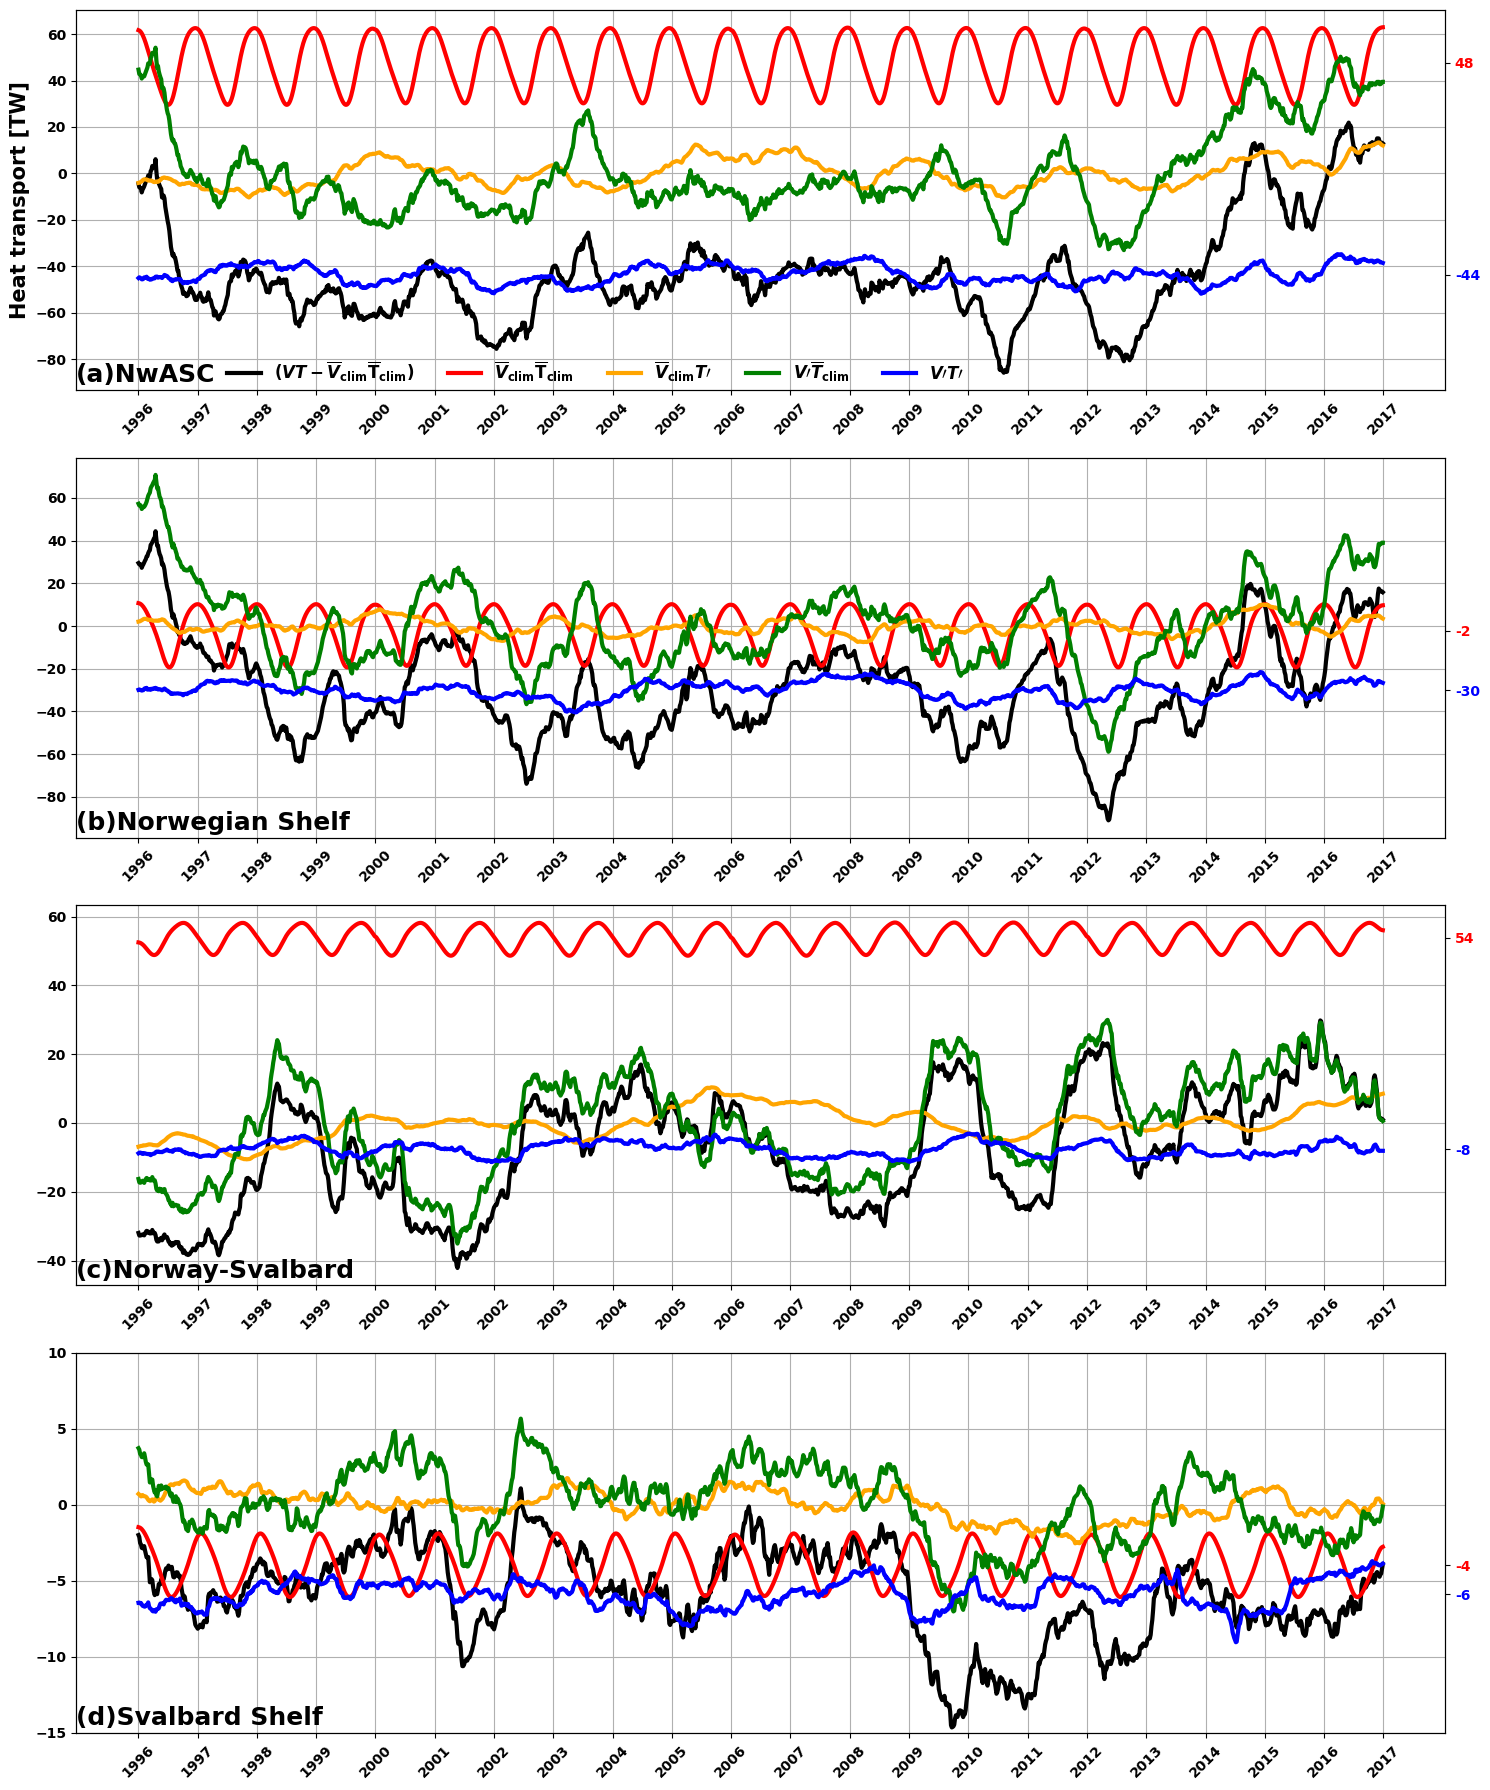

In [78]:
fig, ax = plt.subplots(4, 1, figsize=(15, 18), layout='constrained', sharex=False)
# Data for each section
sections = [
    (NwASC_anom, NwASC_theta, NwASC_volume, NwASC_eddy, NwASC_mean),
    (H_anom_s1_1Y_runningmean, H_theta_s1_1Y_runningmean, H_volume_s1_1Y_runningmean, H_eddy_s1_1Y_runningmean, H_mean_s1_smoothed),
    (H_anom_s2_1Y_runningmean, H_theta_s2_1Y_runningmean, H_volume_s2_1Y_runningmean, H_eddy_s2_1Y_runningmean, H_mean_s2_smoothed),
    (H_anom_s3_1Y_runningmean, H_theta_s3_1Y_runningmean, H_volume_s3_1Y_runningmean, H_eddy_s3_1Y_runningmean, H_mean_s3_smoothed),
]

def plot_section(ax, time, H_anom, H_theta, H_volume, H_eddy,H_mean ):
    ax.plot(time, H_anom, label=r"($ VT-\overline{V}_{\mathrm{clim}}\overline{\mathbf{T}}_{\mathrm{clim}}$)", linestyle='-', color='k', lw=3)
    ax.plot(time, H_mean, label=r"$\overline{V}_{\mathrm{clim}}\overline{\mathbf{T}}_{\mathrm{clim}}$", linestyle='-', color='r', lw=3)
    ax.plot(time, H_theta, label=r"$ \overline{V}_{\mathrm{clim}}T\prime$", linestyle='-', color='orange', lw=3)
    ax.plot(time, H_volume, label=r"$ V\prime\overline{T}_{\mathrm{clim}} $", linestyle='-', color='g', lw=3)
    ax.plot(time, H_eddy, label=r"$ V\prime T\prime $", linestyle='-', color='b', lw=3)
    ax.grid()


# Loop through sections and plot
ax2_dict = {}  # Dictionary to store ax2 objects
for i, (H_anom, H_theta, H_volume, H_eddy, H_mean) in enumerate(sections):
    plot_section(ax[i], WEST_BOUNDARY_using_snap.time, H_anom, H_theta, H_volume, H_eddy, H_mean)
    
    ax[-1].set_ylim(-15,10)
    ax2 = ax[i].twinx()  # 共享同一个 x 轴
    ax2.set_ylim(ax[i].get_ylim())
    ax2_dict[i] = ax2 
    # 计算所有变量的均值
    mean_value = {
        'H_eddy': np.mean(H_eddy),
        'H_mean': np.mean(H_mean),
    }
    
    # 颜色映射
    colors = { 'H_eddy': 'b', 'H_mean': 'r',}
    # 设置右侧 y 轴的所有刻度
    mean_values_list = list(mean_value.values())
    ax2.set_yticks(mean_values_list)
    #ax2.set_yticklabels([f'{v:.0f}' for v in mean_values_list])  # 先设置文本
    ax2.set_yticklabels([f'{int(math.ceil(v))}' for v in mean_values_list]) 
    # 在右侧 y 轴标记均值并添加 marker
    for (key, mean), label in zip(mean_value.items(), ax2.yaxis.get_majorticklabels()):
        label.set_color(colors[key])  # 设置刻度文本颜色
        
    ax2.spines['right'].set_visible(True)  # 显示右侧 y 轴


ax2_dict[0].set_yticklabels(["-44","48"])
ax2_dict[1].set_yticklabels(["-30","-2"])
ax2_dict[2].set_yticklabels(["-8","54"])
ax2_dict[3].set_yticklabels(["-6","-4"])


labels= ["(a)NwASC","(b)Norwegian Shelf","(c)Norway-Svalbard","(d)Svalbard Shelf"]
for axes, label,  in zip(ax, labels, ):
    axes.text(0, 0.07, label, fontsize=18, va='top', ha='left', weight="bold", 
           transform=axes.transAxes)
    axes.set_xticks(pd.date_range(start="1996-01-01", end="2017-12-31", freq='YS'), 
           labels=[str(year) for year in range(1996, 2018)], rotation=45)
#ax[-1].legend(loc='best', title=r"$ (T\mathbf{V})\prime = T\,\,{\mathbf{V}}- \overline{T}_{\mathrm{clim}}\overline{\mathbf{V}}_{\mathrm{clim}}=T\prime \overline{V}_{\mathrm{clim}}  + \overline{T}_{\mathrm{clim}} {\mathbf{V}}\prime   + T\prime \mathbf{V} \prime  $", title_fontsize=14, fontsize=14, ncols=5)

ax[0].legend(loc="best",  bbox_to_anchor=(0.66, 0.12), ncol=5, frameon=False, fontsize=12, )
#ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=5, frameon=False)
ax[0].set_ylabel("Heat transport [TW]", fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('../Manuscript/FIGs/FIG8.png', bbox_inches='tight', transparent=True,dpi=500)
